# Import Data/ packages

In [129]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats
import statsmodels.api as sm
import math
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.pandas.set_option('display.max_columns',None)

In [130]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [131]:
train=pd.read_csv("/content/drive/MyDrive/NFT Price Prediction/dataset/nfts_train.csv")

In [132]:
train.head()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,last_sale_price
0,21928,0,49,2.000000,NaN,NaN,NaN,2022-11,1.266732
1,32621,0,45,97.077216,NaN,NaN,NaN,2021-08,1.200357
2,32622,1,45,139.453086,NaN,NaN,NaN,2022-08,3.180572
3,32623,2,45,127.753445,NaN,NaN,NaN,2021-08,3.502910
4,32624,3,45,112.315719,NaN,NaN,NaN,2022-09,4.009567


In [133]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309910 entries, 0 to 309909
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   global_index         309910 non-null  int64  
 1   nft_id               309910 non-null  int64  
 2   collection_id        309910 non-null  int64  
 3   rarity_score         309910 non-null  float64
 4   openrarity_score     80480 non-null   float64
 5   openrarity_rank      80480 non-null   float64
 6   openrarity_max_rank  80480 non-null   float64
 7   last_sale_date       309910 non-null  object 
 8   last_sale_price      309910 non-null  float64
dtypes: float64(5), int64(3), object(1)
memory usage: 21.3+ MB


In [134]:
test=pd.read_csv('/content/drive/MyDrive/NFT Price Prediction/dataset/nfts_predict.csv')

In [135]:
test.head()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date
0,0,0,29,176.364208,NaN,NaN,NaN,2022-06
1,1,1,29,207.209228,NaN,NaN,NaN,2022-05
2,2,2,29,157.293414,NaN,NaN,NaN,2022-10
3,3,3,29,173.372185,NaN,NaN,NaN,2022-06
4,4,4,29,190.077584,NaN,NaN,NaN,2022-06


In [136]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181214 entries, 0 to 181213
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   global_index         181214 non-null  int64  
 1   nft_id               181214 non-null  int64  
 2   collection_id        181214 non-null  int64  
 3   rarity_score         181214 non-null  float64
 4   openrarity_score     38626 non-null   float64
 5   openrarity_rank      38626 non-null   float64
 6   openrarity_max_rank  38626 non-null   float64
 7   last_sale_date       181214 non-null  object 
dtypes: float64(4), int64(3), object(1)
memory usage: 11.1+ MB


In [137]:
train['global_index'].unique()

array([ 21928,  32621,  32622, ..., 590225, 590226, 590227])

In [138]:
test['global_index'].unique()

array([     0,      1,      2, ..., 618139, 618140, 618141])

In [139]:
collections=pd.read_csv('/content/drive/MyDrive/NFT Price Prediction/dataset/collections.csv')
collections=collections.iloc[:,1:]
collections.head()

,collection_id,total_supply,creation_date,verification_status,n_of_traits,contract_type,seller_fees,platform_fees,openrarity_enabled,has_website,has_own_twitter,has_discord,has_medium
0,19,1000,2021-04,verified,4,own,500.0,250,False,False,True,True,True
1,45,8888,2021-07,verified,5,own,500.0,250,False,False,True,True,False
2,44,10000,2022-04,verified,8,own,500.0,250,True,False,True,True,False
3,53,9999,2022-07,verified,9,own,900.0,250,False,False,True,True,False
4,6,9602,2021-06,verified,8,own,NaN,250,False,False,True,True,False


In [140]:
twitter=pd.read_csv('/content/drive/MyDrive/NFT Price Prediction/dataset/collections_twitter_stats.csv')
twitter=twitter.iloc[:,1:]
twitter.head()

,collection_id,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets
0,0,2,183.000000,8.500000,41.000000,123,3,6,243,14,76
1,1,16,36.375000,3.562500,13.937500,0,0,0,125,21,34
2,2,1,15.000000,9.000000,1.000000,15,9,1,15,9,1
3,3,526,1.178707,0.306084,2.655894,0,0,0,21,8,13
4,4,26,8.153846,0.884615,1.153846,0,0,0,30,6,12


In [141]:
df=pd.concat([train,test],axis='rows')

In [142]:
df=pd.merge(df,twitter, on=['collection_id'],how='left')
df=pd.merge(df,collections, on=['collection_id'],how='left')

## Final Data Set
### Collections & Twitter datasets are merged with primary data using "collection_id"

In [143]:
df.head()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,last_sale_price,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets,total_supply,creation_date,verification_status,n_of_traits,contract_type,seller_fees,platform_fees,openrarity_enabled,has_website,has_own_twitter,has_discord,has_medium
0,21928,0,49,2.000000,NaN,NaN,NaN,2022-11,1.266732,31,187.967742,8.290323,60.935484,0,0,2,591,28,380,1,2022-04,verified,2,own,1000.0,250,False,False,True,True,False
1,32621,0,45,97.077216,NaN,NaN,NaN,2021-08,1.200357,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,8888,2021-07,verified,5,own,500.0,250,False,False,True,True,False
2,32622,1,45,139.453086,NaN,NaN,NaN,2022-08,3.180572,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,8888,2021-07,verified,5,own,500.0,250,False,False,True,True,False
3,32623,2,45,127.753445,NaN,NaN,NaN,2021-08,3.502910,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,8888,2021-07,verified,5,own,500.0,250,False,False,True,True,False
4,32624,3,45,112.315719,NaN,NaN,NaN,2022-09,4.009567,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,8888,2021-07,verified,5,own,500.0,250,False,False,True,True,False


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 491124 entries, 0 to 491123
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   global_index         491124 non-null  int64  
 1   nft_id               491124 non-null  int64  
 2   collection_id        491124 non-null  int64  
 3   rarity_score         491124 non-null  float64
 4   openrarity_score     119106 non-null  float64
 5   openrarity_rank      119106 non-null  float64
 6   openrarity_max_rank  119106 non-null  float64
 7   last_sale_date       491124 non-null  object 
 8   last_sale_price      309910 non-null  float64
 9   n_tweets_in_range    491124 non-null  int64  
 10  avg_likes            491124 non-null  float64
 11  avg_replies          491124 non-null  float64
 12  avg_retweets         491124 non-null  float64
 13  min_likes            491124 non-null  int64  
 14  min_replies          491124 non-null  int64  
 15  min_retweets     

In [145]:
df['openrarity_max_rank'].value_counts()

10000.0    20000
9999.0     19998
15555.0    15555
15000.0    15000
5555.0     11110
9854.0     10000
9928.0      9928
8849.0      8888
5295.0      5295
3332.0      3332
Name: openrarity_max_rank, dtype: int64

In [146]:
df_na=df[df['openrarity_max_rank'].isna()==True]

In [147]:
# df[df['nft_id']==0]

In [148]:
'''
Rarity Score is not available, for now this can be assumed with zero rarity score. Or Use a regression to identify the rarity score
'''

'\nRarity Score is not available, for now this can be assumed with zero rarity score. Or Use a regression to identify the rarity score\n'

# Missing Values

In [149]:
missing_feat=[feature for feature in df.columns if df[feature].isna().sum()>0 and feature not in ['last_sale_price']]
missing_feat

['openrarity_score', 'openrarity_rank', 'openrarity_max_rank', 'seller_fees']

In [150]:
df['seller_fees'].fillna(df['seller_fees'].median(),inplace=True)

In [151]:
missing_feat=[feature for feature in df.columns if df[feature].isna().sum()>0 and feature not in ['last_sale_price']]
missing_feat

['openrarity_score', 'openrarity_rank', 'openrarity_max_rank']

In [152]:
df[missing_feat].nunique()/df.shape[0]*100

openrarity_score       21.058836
openrarity_rank         3.167225
openrarity_max_rank     0.002036
dtype: float64

In [153]:
'''
We can see that for openrarity_rank and openrarity_max_rank, the unique values are less than 10% of the total population and hence can be treated as descrete/categorical. 
openrarity_score can be filles with zero as the scores are not available
'''

'\nWe can see that for openrarity_rank and openrarity_max_rank, the unique values are less than 10% of the total population and hence can be treated as descrete/categorical. \nopenrarity_score can be filles with zero as the scores are not available\n'

In [154]:
df['openrarity_rank']=df['openrarity_rank'].astype('str')
df['openrarity_rank'].fillna("Missing_r",inplace=True)

df['openrarity_max_rank']=df['openrarity_max_rank'].astype('str')
df['openrarity_max_rank'].fillna("Missing_m_r",inplace=True)

df['openrarity_score'].fillna(0,inplace=True)

In [155]:
df['openrarity_enabled'].sum()

119106

In [156]:
# for f in missing_feat:
#   df[f].fillna(0,inplace=True)

In [157]:
df['openrarity_score'].sum()

119106.0

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 491124 entries, 0 to 491123
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   global_index         491124 non-null  int64  
 1   nft_id               491124 non-null  int64  
 2   collection_id        491124 non-null  int64  
 3   rarity_score         491124 non-null  float64
 4   openrarity_score     491124 non-null  float64
 5   openrarity_rank      491124 non-null  object 
 6   openrarity_max_rank  491124 non-null  object 
 7   last_sale_date       491124 non-null  object 
 8   last_sale_price      309910 non-null  float64
 9   n_tweets_in_range    491124 non-null  int64  
 10  avg_likes            491124 non-null  float64
 11  avg_replies          491124 non-null  float64
 12  avg_retweets         491124 non-null  float64
 13  min_likes            491124 non-null  int64  
 14  min_replies          491124 non-null  int64  
 15  min_retweets     

In [159]:
''' These features have only one unique values and so are redundant'''
no_use_feat=[feature for feature in df.columns if df[feature].nunique()==1]
no_use_feat

['platform_fees', 'has_website', 'has_own_twitter']

In [160]:
df.drop(columns=no_use_feat,inplace=True)

# EDA

In [161]:
df.head()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,last_sale_price,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets,total_supply,creation_date,verification_status,n_of_traits,contract_type,seller_fees,openrarity_enabled,has_discord,has_medium
0,21928,0,49,2.000000,0.0,nan,nan,2022-11,1.266732,31,187.967742,8.290323,60.935484,0,0,2,591,28,380,1,2022-04,verified,2,own,1000.0,False,True,False
1,32621,0,45,97.077216,0.0,nan,nan,2021-08,1.200357,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,8888,2021-07,verified,5,own,500.0,False,True,False
2,32622,1,45,139.453086,0.0,nan,nan,2022-08,3.180572,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,8888,2021-07,verified,5,own,500.0,False,True,False
3,32623,2,45,127.753445,0.0,nan,nan,2021-08,3.502910,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,8888,2021-07,verified,5,own,500.0,False,True,False
4,32624,3,45,112.315719,0.0,nan,nan,2022-09,4.009567,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,8888,2021-07,verified,5,own,500.0,False,True,False


In [162]:
df.nunique()/df.shape[0]*100

global_index           100.000000
nft_id                   9.825828
collection_id            0.009773
rarity_score            89.970150
openrarity_score        21.059040
openrarity_rank          3.167428
openrarity_max_rank      0.002240
last_sale_date           0.004480
last_sale_price         63.102190
n_tweets_in_range        0.005498
avg_likes                0.008552
avg_replies              0.008348
avg_retweets             0.008552
min_likes                0.002443
min_replies              0.001629
min_retweets             0.003665
max_likes                0.008145
max_replies              0.006719
max_retweets             0.007330
total_supply             0.007737
creation_date            0.003869
verification_status      0.000407
n_of_traits              0.004480
contract_type            0.000407
seller_fees              0.001833
openrarity_enabled       0.000407
has_discord              0.000407
has_medium               0.000407
dtype: float64

In [163]:
''' Most of the features are descrete, this leaves the opputunity to treat them as categorical based on performance'''

' Most of the features are descrete, this leaves the opputunity to treat them as categorical based on performance'

In [164]:
df['collection_id'].value_counts()

39    48257
46    29899
35    25492
36    24154
13    23091
2     20216
58    15555
1     15000
44    10000
18    10000
26    10000
27    10000
7     10000
31    10000
22    10000
53     9999
50     9999
28     9999
29     9999
23     9998
54     9928
8      9667
6      9602
59     9508
3      9061
4      9000
37     8888
45     8888
5      8638
15     7902
43     7751
42     7145
14     6969
0      6501
34     5555
38     5555
47     5295
51     5080
30     5022
48     4582
25     3997
57     3900
41     3781
10     3332
24     2498
19     1000
60      420
49        1
Name: collection_id, dtype: int64

## Numerical Features

In [166]:
'''Convert date features to datetime'''
df['last_sale_date']=pd.to_datetime(df['last_sale_date'])
df['creation_date']=pd.to_datetime(df['creation_date'])

In [167]:
''' Extract new features such as year and month'''
df['sale_year']=df['last_sale_date'].dt.year
df['sale_month']=df['last_sale_date'].dt.month

### Time bt creation to last sale

#### Even time between the previous sale and current sale can be calculated for each NFT ID

In [169]:
df["creation_to_last_sale"]=(df["last_sale_date"]-df['creation_date']).dt.days

### Age of NFT

In [171]:
# df['nft_age']=(pd.to_datetime("now")-df['creation_date']).dt.days
''' Since the sales happened sometime in the past, this is not useful'''

' Since the sales happened sometime in the past, this is not useful'

In [172]:
'''After extracting year, month, gap between creation and last sale. I', converting these to categorical as there are only a few dates where the sale is happening'''
df['creation_date']='c_dt_'+df['creation_date'].astype(str)
df['last_sale_date']='l_dt_'+df['last_sale_date'].astype(str)

In [173]:
'''Extract Numerical Features'''

num_features=[feature for feature in df.columns if df[feature].dtypes!='O' and df[feature].dtypes!=bool]
print('Number of numerical vairables are:', len(num_features))

Number of numerical vairables are: 22


In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 491124 entries, 0 to 491123
Data columns (total 31 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   global_index           491124 non-null  int64  
 1   nft_id                 491124 non-null  int64  
 2   collection_id          491124 non-null  int64  
 3   rarity_score           491124 non-null  float64
 4   openrarity_score       491124 non-null  float64
 5   openrarity_rank        491124 non-null  object 
 6   openrarity_max_rank    491124 non-null  object 
 7   last_sale_date         491124 non-null  object 
 8   last_sale_price        309910 non-null  float64
 9   n_tweets_in_range      491124 non-null  int64  
 10  avg_likes              491124 non-null  float64
 11  avg_replies            491124 non-null  float64
 12  avg_retweets           491124 non-null  float64
 13  min_likes              491124 non-null  int64  
 14  min_replies            491124 non-nu

### Descrete Features

In [49]:
df.nunique()

global_index             491124
nft_id                    48257
collection_id                48
rarity_score             441865
openrarity_score         103426
openrarity_rank           15556
openrarity_max_rank          11
last_sale_date               22
last_sale_price          309910
n_tweets_in_range            27
avg_likes                    42
avg_replies                  41
avg_retweets                 42
min_likes                    12
min_replies                   8
min_retweets                 18
max_likes                    40
max_replies                  33
max_retweets                 36
total_supply                 38
creation_date                19
verification_status           2
n_of_traits                  22
contract_type                 2
seller_fees                   9
openrarity_enabled            2
has_discord                   2
has_medium                    2
sale_year                     2
sale_month                   12
creation_to_last_sale        70
dtype: i

In [175]:
''' All features with less than 100 unique values have been considered descrete as 100/491124 is <1%'''
disc_feature=[feature for feature in num_features if len(df[feature].unique())<100]
print("Discrete Variables Count: {}".format(len(disc_feature)))

Discrete Variables Count: 17


In [176]:
disc_feature

['collection_id',
 'n_tweets_in_range',
 'avg_likes',
 'avg_replies',
 'avg_retweets',
 'min_likes',
 'min_replies',
 'min_retweets',
 'max_likes',
 'max_replies',
 'max_retweets',
 'total_supply',
 'n_of_traits',
 'seller_fees',
 'sale_year',
 'sale_month',
 'creation_to_last_sale']

In [177]:
df[disc_feature].nunique()

collection_id            48
n_tweets_in_range        27
avg_likes                42
avg_replies              41
avg_retweets             42
min_likes                12
min_replies               8
min_retweets             18
max_likes                40
max_replies              33
max_retweets             36
total_supply             38
n_of_traits              22
seller_fees               9
sale_year                 2
sale_month               12
creation_to_last_sale    70
dtype: int64

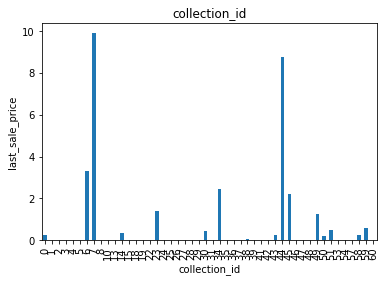

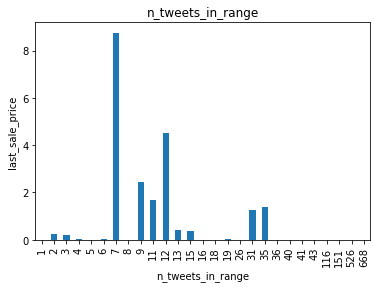

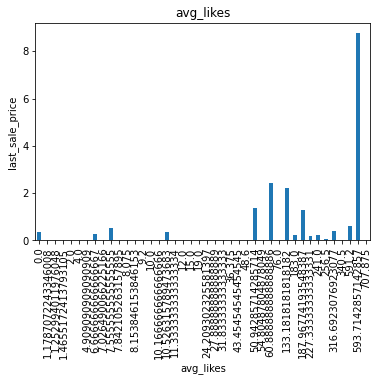

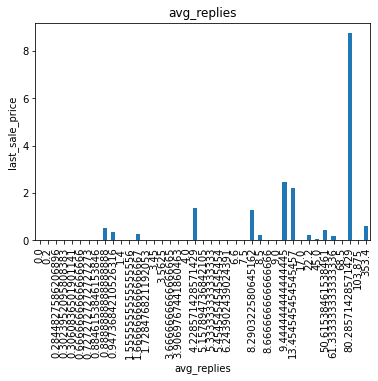

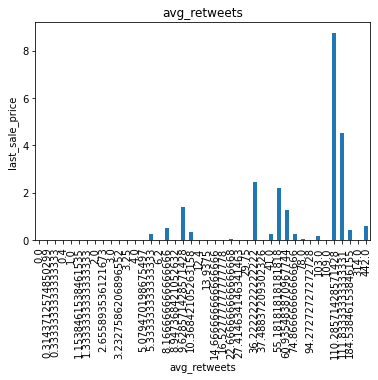

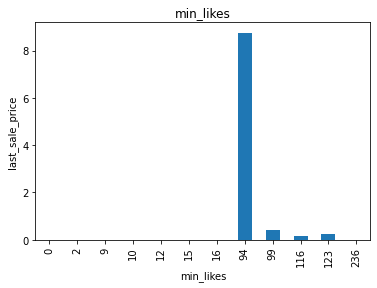

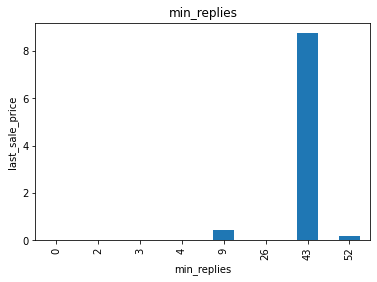

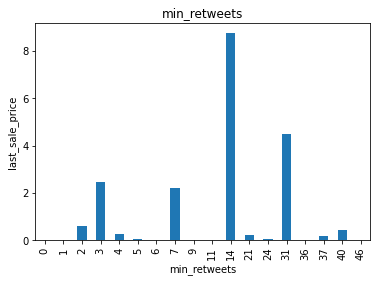

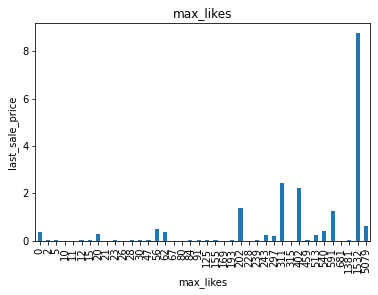

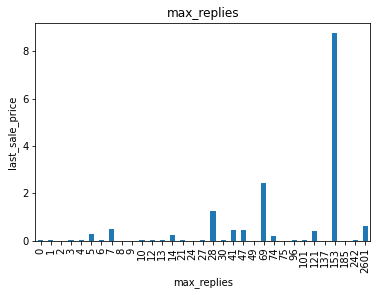

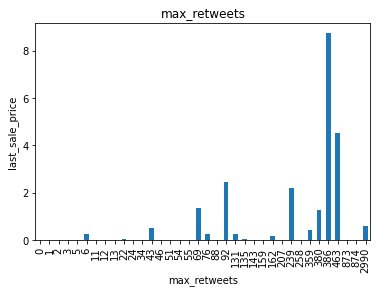

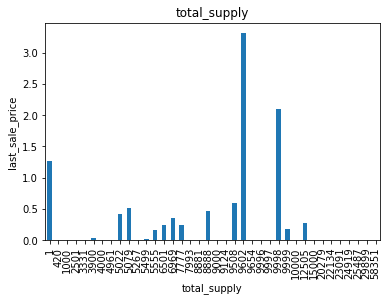

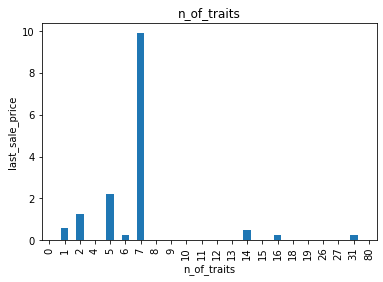

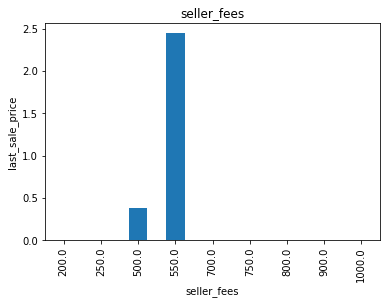

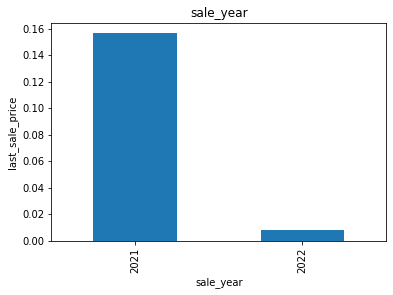

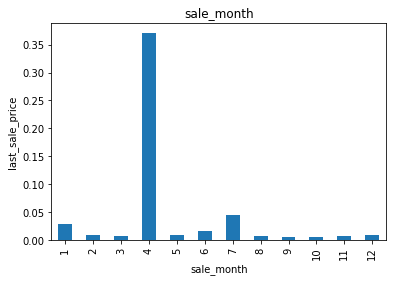

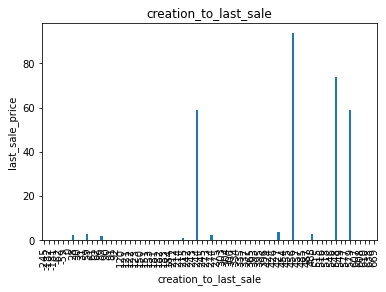

In [178]:
for feature in disc_feature:
    data=df.copy()
    data.groupby(feature)['last_sale_price'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('last_sale_price')
    plt.title(feature)
    plt.show()

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


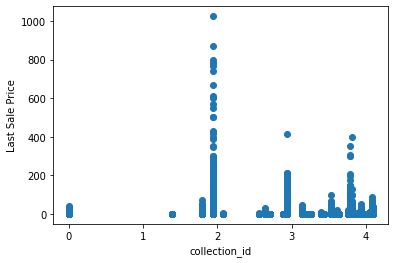

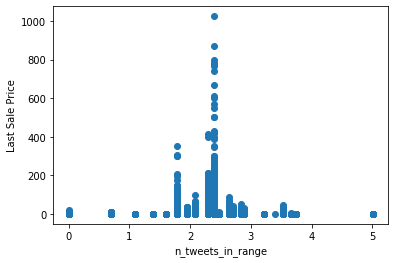

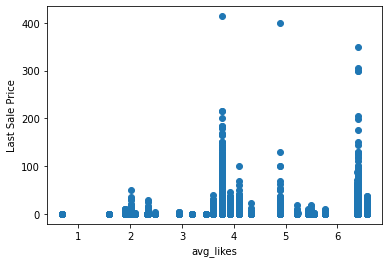

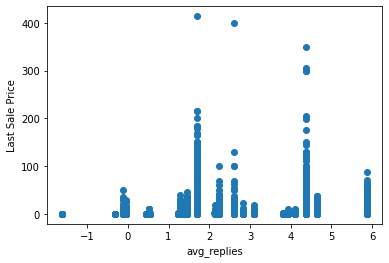

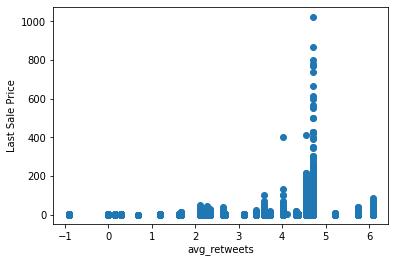

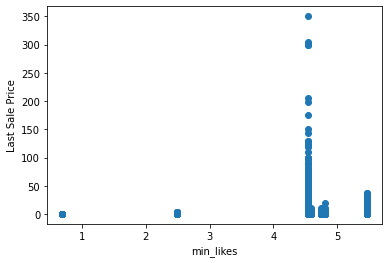

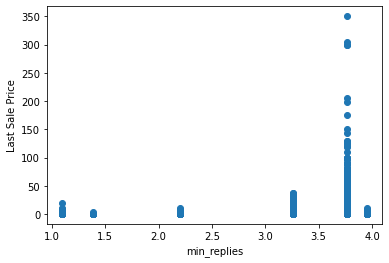

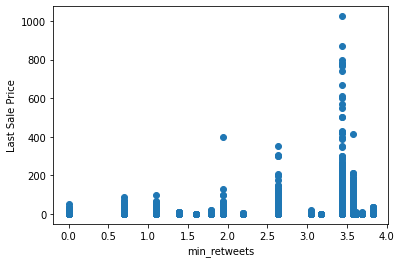

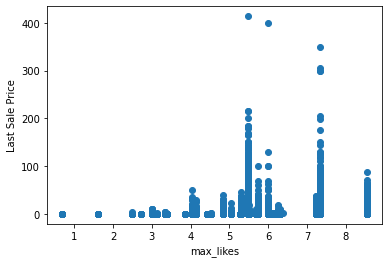

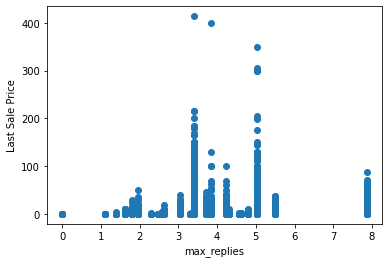

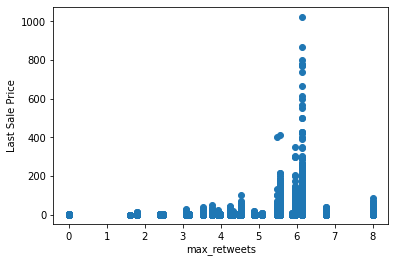

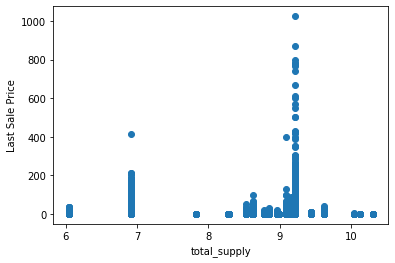

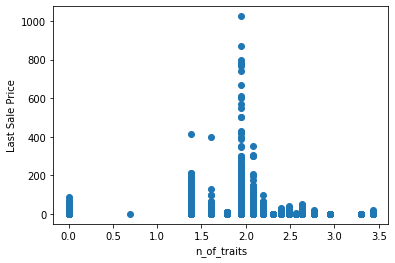

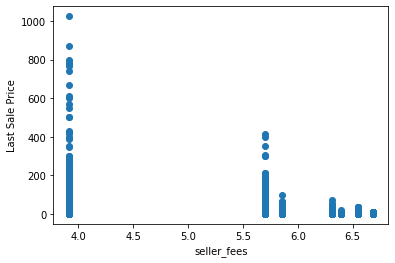

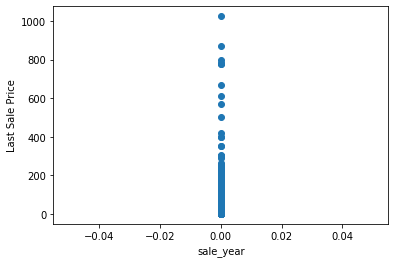

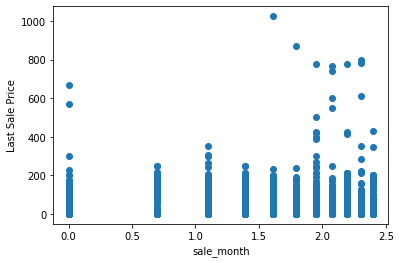

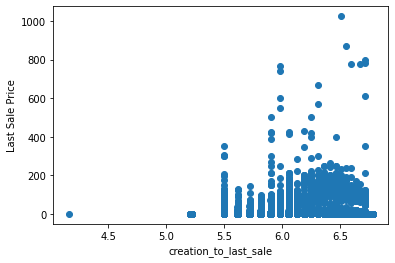

In [179]:
for feature in disc_feature:
    data=df.copy()
    # if 0 in df[feature].unique():
    #     pass
    # else:
    data[feature]=np.log(data[feature]-data[feature].min())
    # df['last_sale_price']=np.log(df['last_sale_price'])
    plt.scatter(data[feature],data['last_sale_price'])
    plt.xlabel(feature)
    plt.ylabel('Last Sale Price')
    plt.show()
    

In [180]:
'''
Only NFT Age shows a trend with the price, the others can be converted to to categorical features'''

'\nOnly NFT Age shows a trend with the price, the others can be converted to to categorical features'

#### Bool to Num
#### Cnvert Boolean to Numerical

In [181]:
bool_feat=[feature for feature in df.columns if df[feature].dtype==bool]
bool_feat

['openrarity_enabled', 'has_discord', 'has_medium']

In [182]:
def bool_clean(x):
  if x==False:
    return(0)
  else:
    return(1)

In [183]:
for f in bool_feat:
  df[f]=df[f].apply(bool_clean)

In [184]:
df[disc_feature].nunique()

collection_id            48
n_tweets_in_range        27
avg_likes                42
avg_replies              41
avg_retweets             42
min_likes                12
min_replies               8
min_retweets             18
max_likes                40
max_replies              33
max_retweets             36
total_supply             38
n_of_traits              22
seller_fees               9
sale_year                 2
sale_month               12
creation_to_last_sale    70
dtype: int64

In [63]:
rest_desc=[f for f in disc_feature if f not in bool_feat]
rest_desc

['collection_id',
 'n_tweets_in_range',
 'avg_likes',
 'avg_replies',
 'avg_retweets',
 'min_likes',
 'min_replies',
 'min_retweets',
 'max_likes',
 'max_replies',
 'max_retweets',
 'total_supply',
 'n_of_traits',
 'seller_fees',
 'sale_year',
 'sale_month',
 'creation_to_last_sale']

In [186]:
''' Tried converting the descrete features into categorical but the performance was depreciating.'''
# for f in rest_desc:
#   df[f+'cat']=f+df[f].astype(str)
#   print(f)

' Tried converting the descrete features into categorical but the performance was depreciating.'

### Dist on Numerical Features

In [187]:
num_features=[feature for feature in df.columns if df[feature].dtypes!='O']
print('Number of numerical vairables are:', len(num_features))
num_features

Number of numerical vairables are: 25


['global_index',
 'nft_id',
 'collection_id',
 'rarity_score',
 'openrarity_score',
 'last_sale_price',
 'n_tweets_in_range',
 'avg_likes',
 'avg_replies',
 'avg_retweets',
 'min_likes',
 'min_replies',
 'min_retweets',
 'max_likes',
 'max_replies',
 'max_retweets',
 'total_supply',
 'n_of_traits',
 'seller_fees',
 'openrarity_enabled',
 'has_discord',
 'has_medium',
 'sale_year',
 'sale_month',
 'creation_to_last_sale']

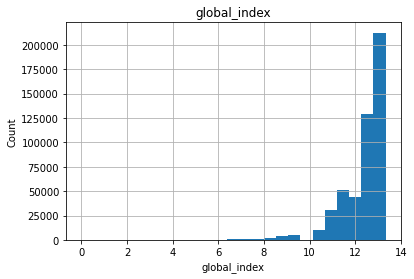

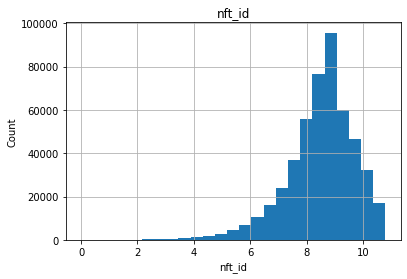

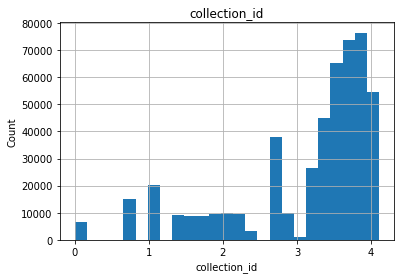

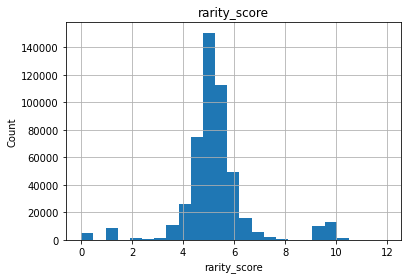

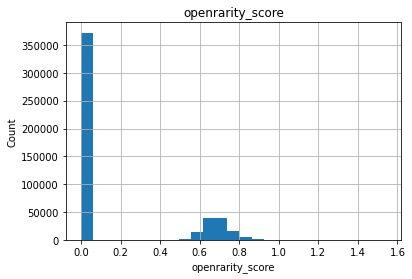

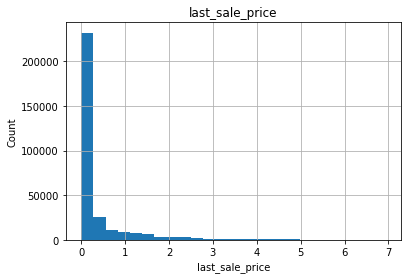

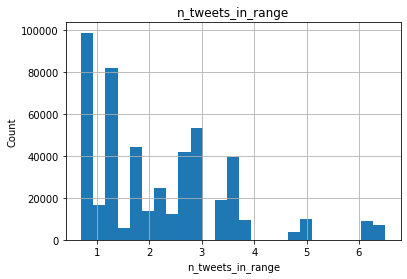

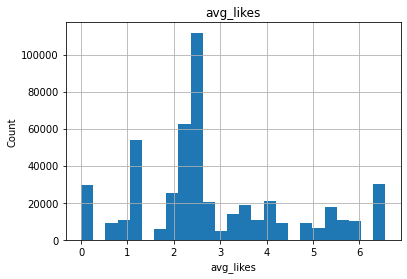

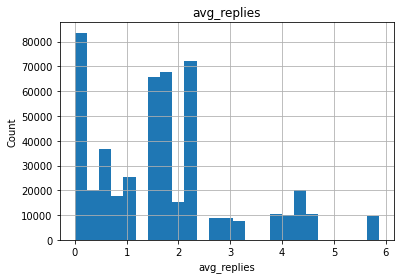

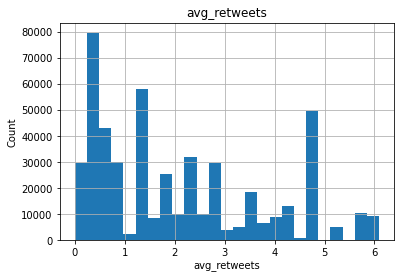

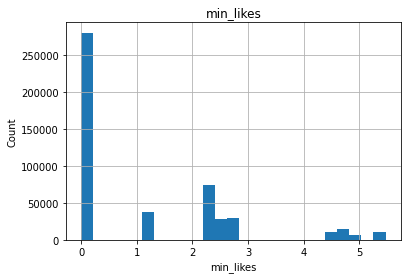

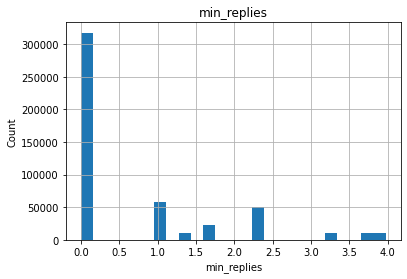

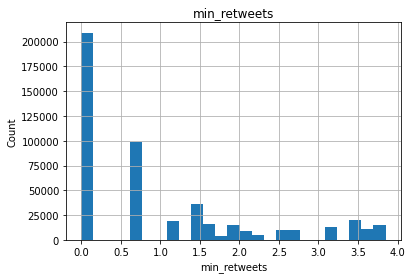

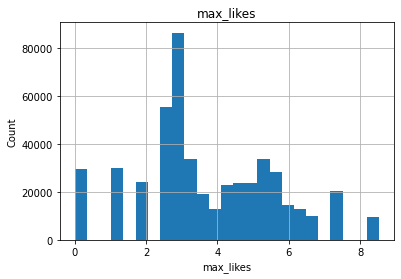

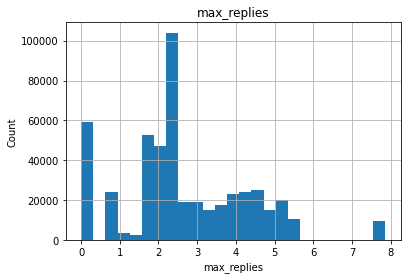

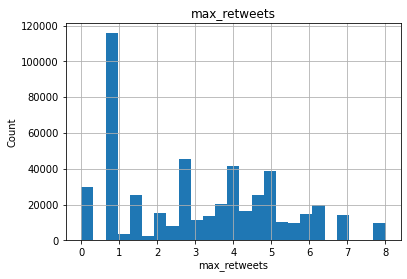

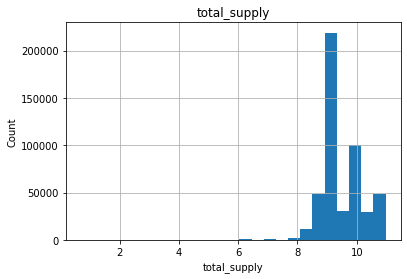

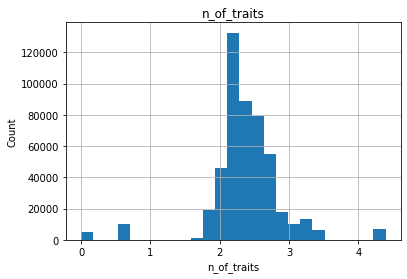

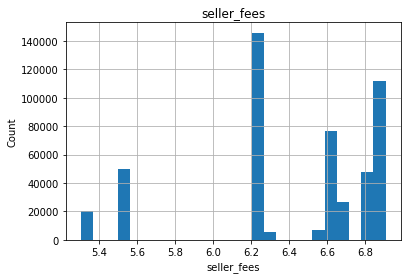

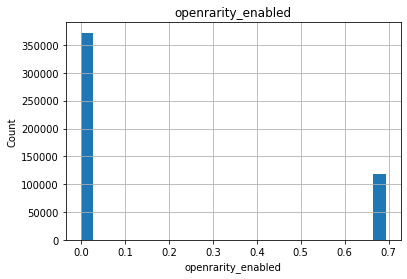

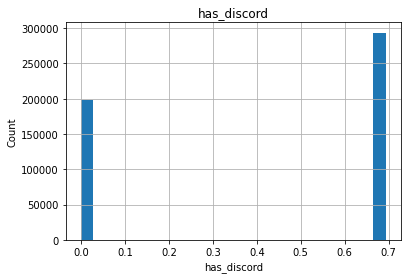

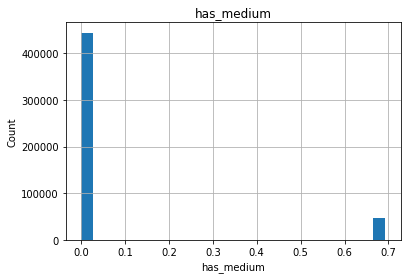

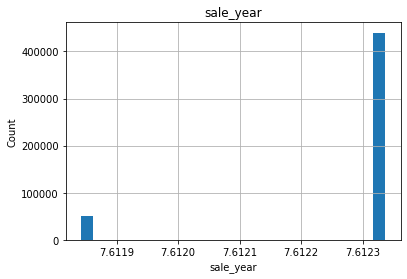

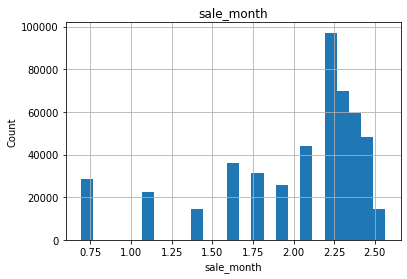

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


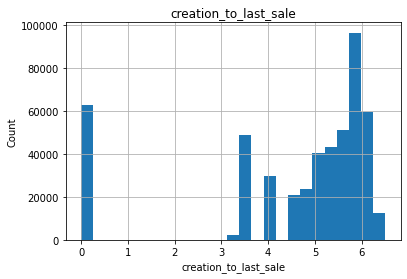

In [188]:
''' Log transformed features had better distributions than the originals'''
for feature in num_features:
    data=df.copy()
    np.log1p(data[feature]).hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

In [67]:
'''Many of the continous features are skewed'''

'Many of the continous features are skewed'

### Scatter Plots

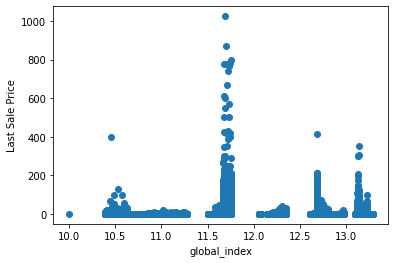

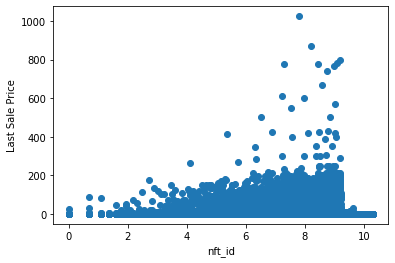

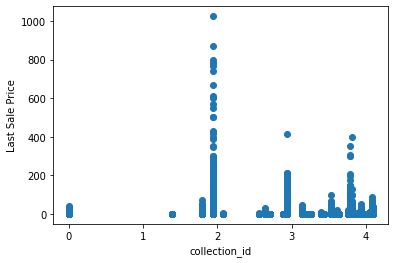

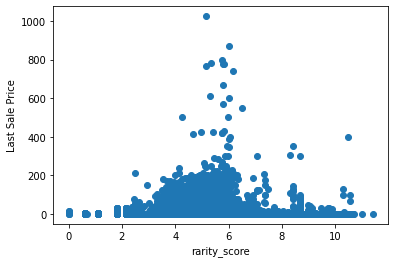

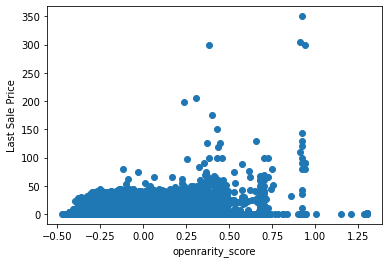

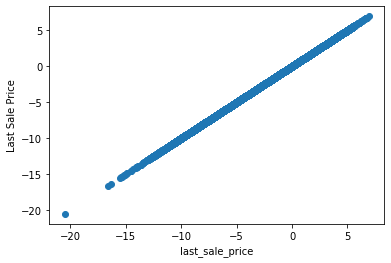

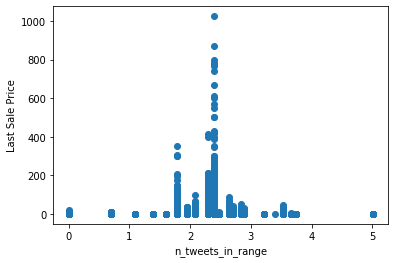

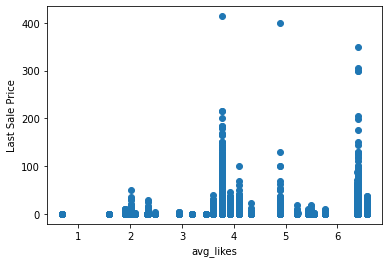

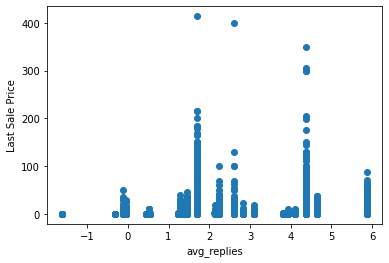

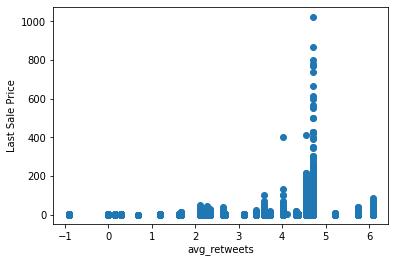

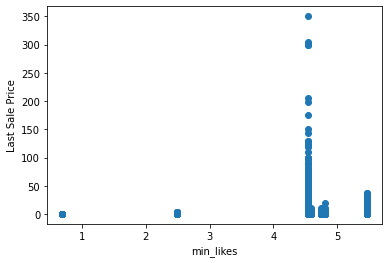

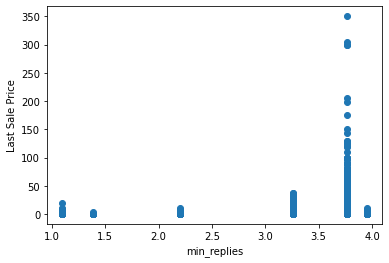

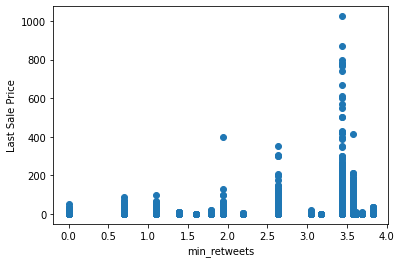

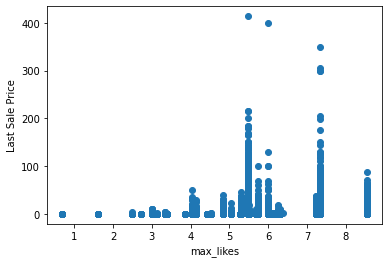

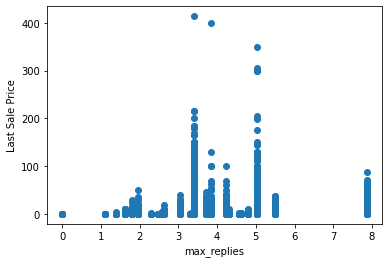

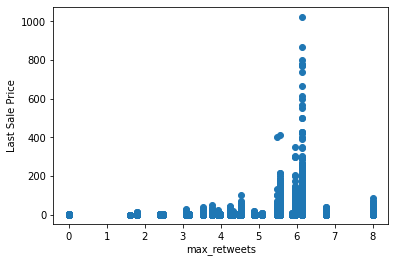

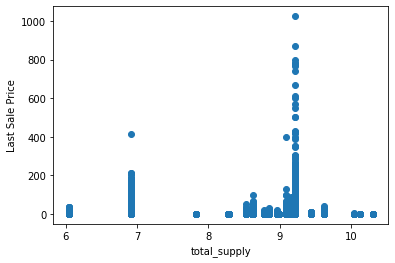

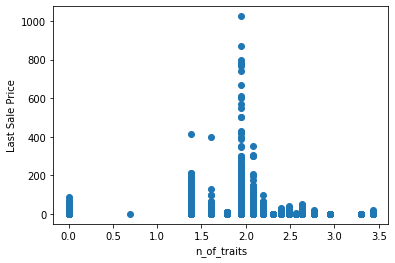

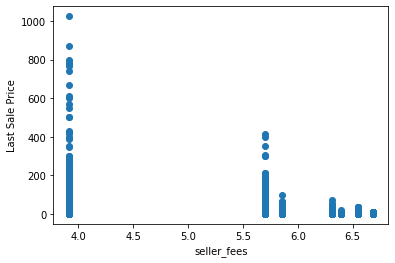

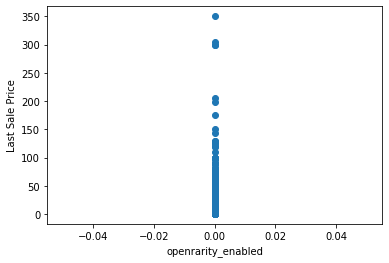

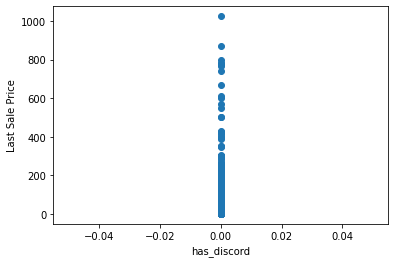

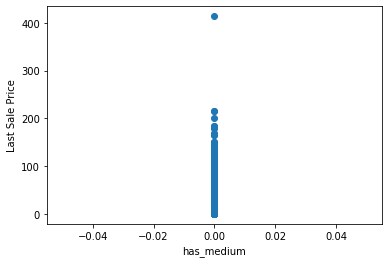

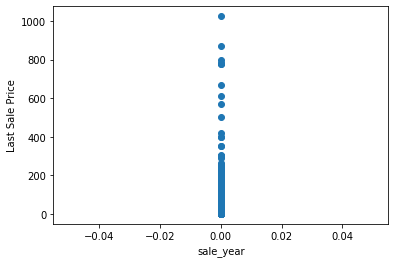

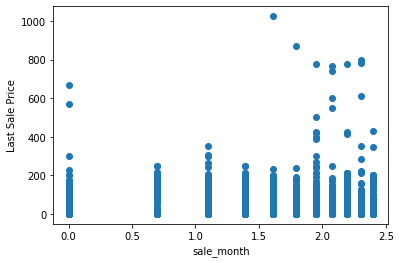

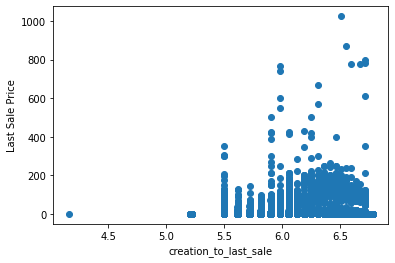

In [189]:
for feature in num_features:
    data=df.copy()
    # if 0 in df[feature].unique():
    #     pass
    # else:
    data[feature]=np.log(data[feature]-data[feature].min())
    # df['last_sale_price']=np.log(df['last_sale_price'])
    plt.scatter(data[feature],data['last_sale_price'])
    plt.xlabel(feature)
    plt.ylabel('Last Sale Price')
    plt.show()
    

### Outliers

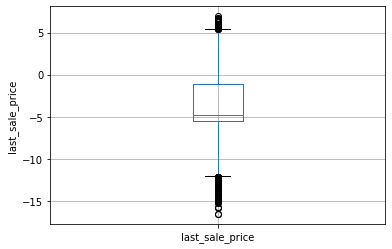

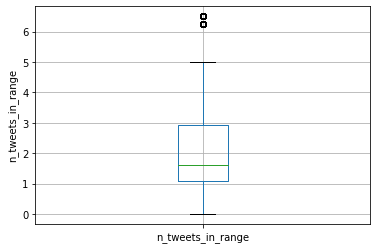

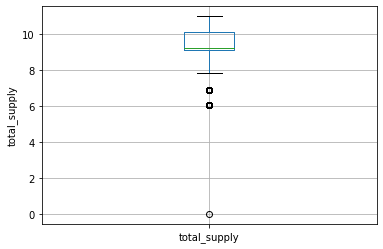

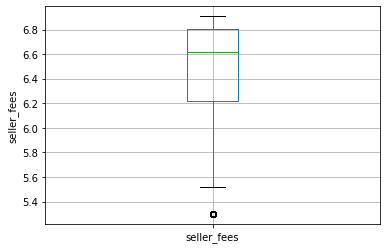

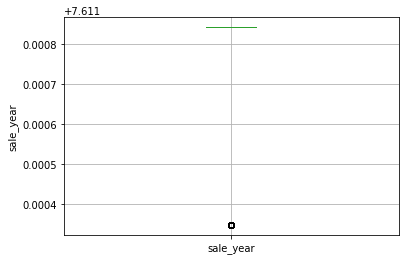

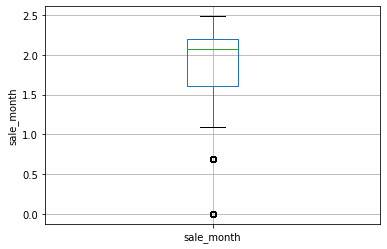

In [190]:
for feature in num_features:
    data=df.copy()
    if 0 in data[feature].unique():
        pass
    else:
        data[feature]=np.log(data[feature])
        data.boxplot(column=feature)
        plt.ylabel(feature)
        plt.show()

In [191]:
'''Significant outliers are present, so algorithms with distance based minimization functions would not work well. Eg; ANNs, Linear Regression. So i would be usng tree based algoritms'''

'Significant outliers are present, so algorithms with distance based minimization functions would not work well. Eg; ANNs, Linear Regression. So i would be usng tree based algoritms'

## Categorical Variables

In [192]:
categorical_features=[feature for feature in df.columns if df[feature].dtypes=='O']
categorical_features

['openrarity_rank',
 'openrarity_max_rank',
 'last_sale_date',
 'creation_date',
 'verification_status',
 'contract_type']

In [193]:
df[categorical_features].nunique()

openrarity_rank        15556
openrarity_max_rank       11
last_sale_date            22
creation_date             19
verification_status        2
contract_type              2
dtype: int64

In [194]:
df[categorical_features].head()

,openrarity_rank,openrarity_max_rank,last_sale_date,creation_date,verification_status,contract_type
0,nan,nan,l_dt_2022-11-01,c_dt_2022-04-01,verified,own
1,nan,nan,l_dt_2021-08-01,c_dt_2021-07-01,verified,own
2,nan,nan,l_dt_2022-08-01,c_dt_2021-07-01,verified,own
3,nan,nan,l_dt_2021-08-01,c_dt_2021-07-01,verified,own
4,nan,nan,l_dt_2022-09-01,c_dt_2021-07-01,verified,own


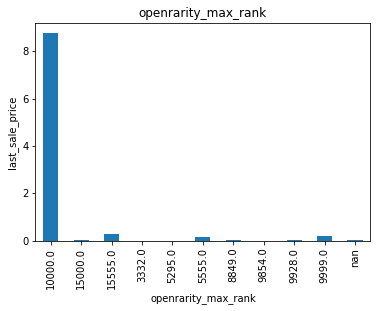

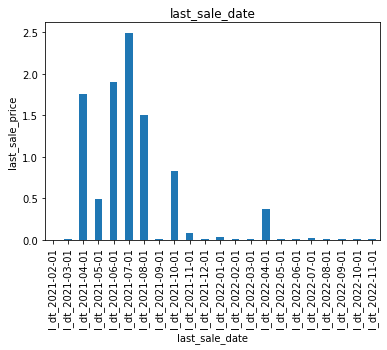

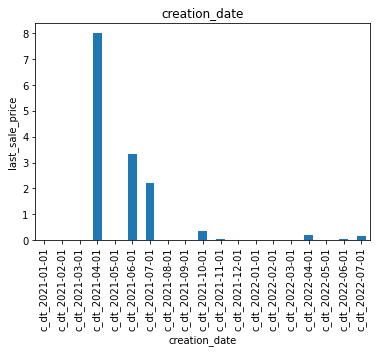

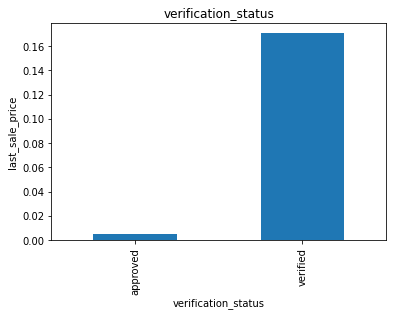

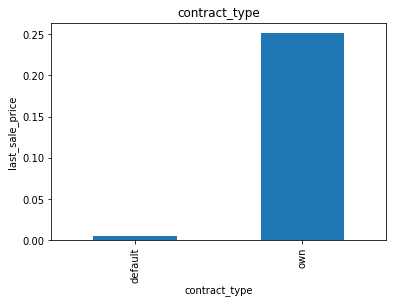

In [195]:
for feature in categorical_features:
  if df[feature].nunique()<25:
    data1=df.copy()
    data1.groupby(feature)['last_sale_price'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('last_sale_price')
    plt.title(feature)
    plt.show()

# Feature Engineering

In [196]:
df[num_features].head()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,last_sale_price,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets,total_supply,n_of_traits,seller_fees,openrarity_enabled,has_discord,has_medium,sale_year,sale_month,creation_to_last_sale
0,21928,0,49,2.000000,0.0,1.266732,31,187.967742,8.290323,60.935484,0,0,2,591,28,380,1,2,1000.0,0,1,0,2022,11,214
1,32621,0,45,97.077216,0.0,1.200357,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,8888,5,500.0,0,1,0,2021,8,31
2,32622,1,45,139.453086,0.0,3.180572,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,8888,5,500.0,0,1,0,2022,8,396
3,32623,2,45,127.753445,0.0,3.502910,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,8888,5,500.0,0,1,0,2021,8,31
4,32624,3,45,112.315719,0.0,4.009567,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,8888,5,500.0,0,1,0,2022,9,427


In [197]:
df[num_features].nunique()

global_index             491124
nft_id                    48257
collection_id                48
rarity_score             441865
openrarity_score         103426
last_sale_price          309910
n_tweets_in_range            27
avg_likes                    42
avg_replies                  41
avg_retweets                 42
min_likes                    12
min_replies                   8
min_retweets                 18
max_likes                    40
max_replies                  33
max_retweets                 36
total_supply                 38
n_of_traits                  22
seller_fees                   9
openrarity_enabled            2
has_discord                   2
has_medium                    2
sale_year                     2
sale_month                   12
creation_to_last_sale        70
dtype: int64

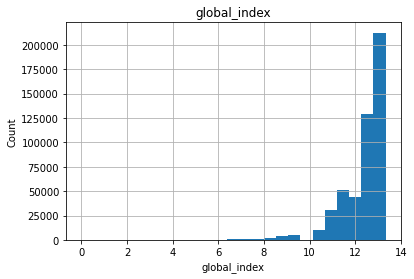

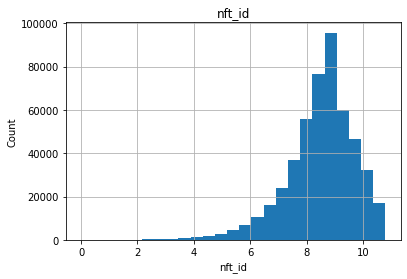

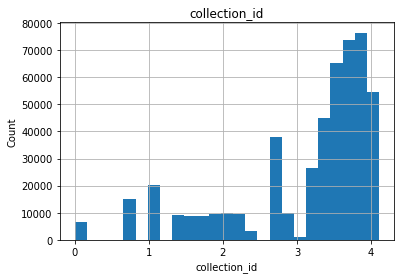

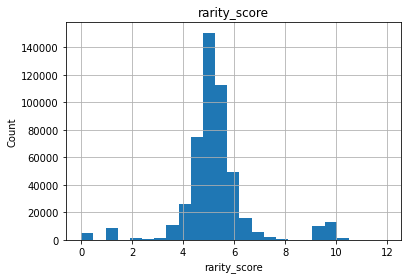

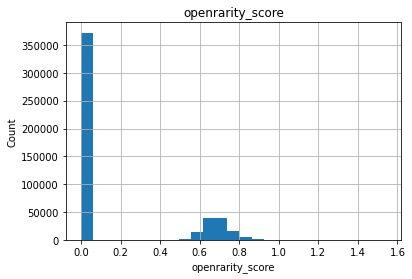

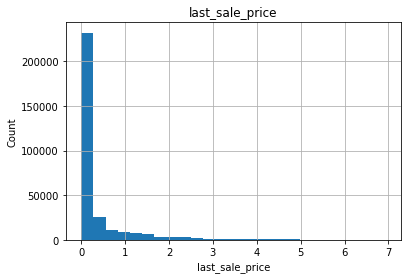

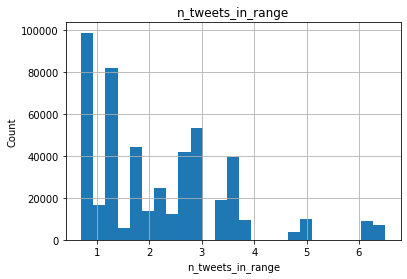

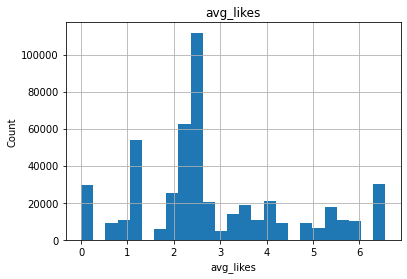

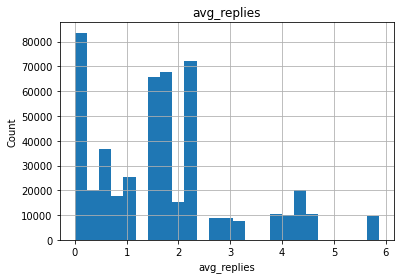

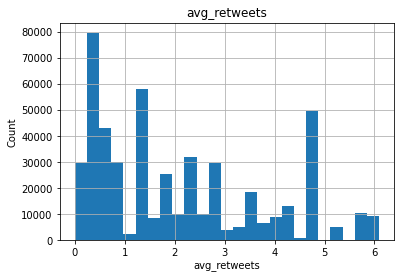

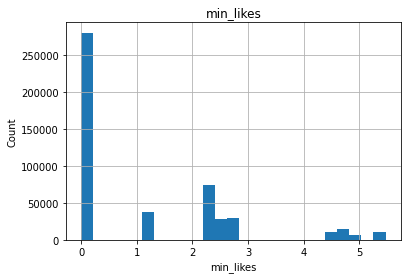

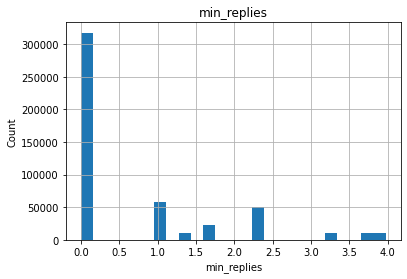

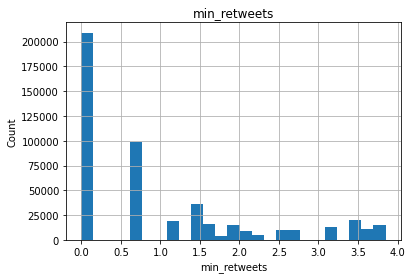

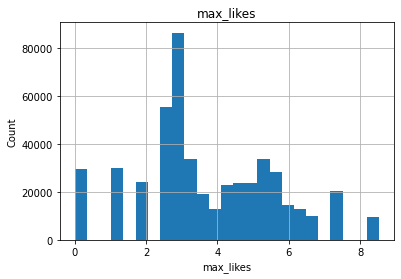

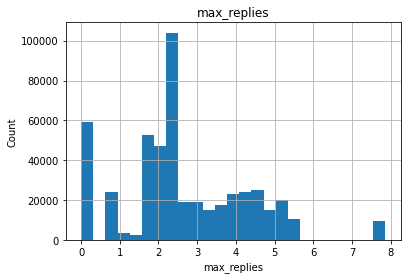

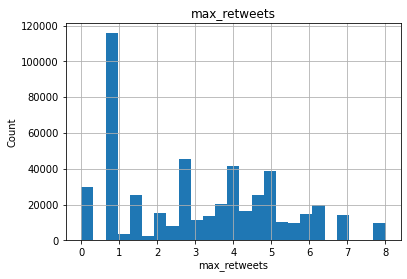

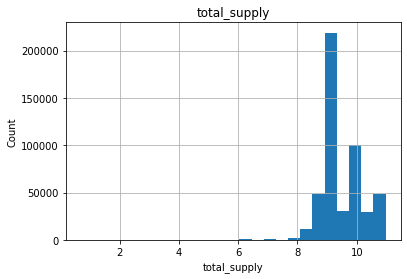

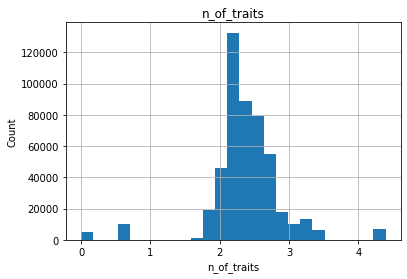

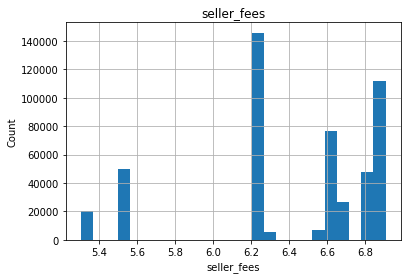

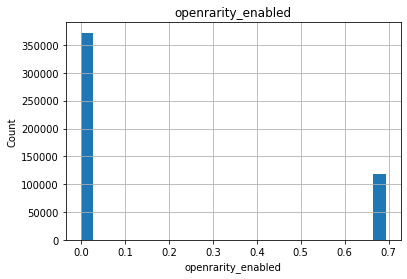

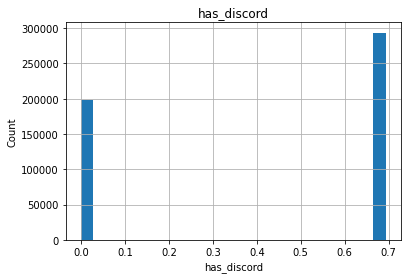

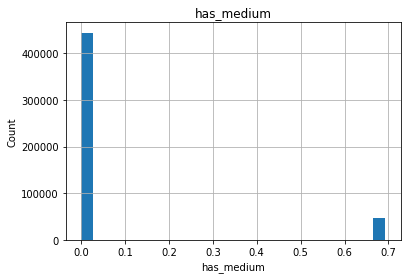

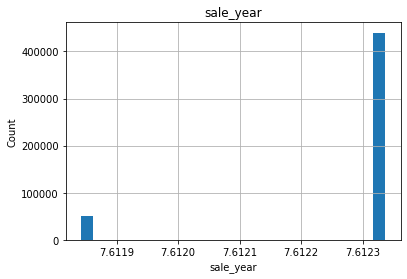

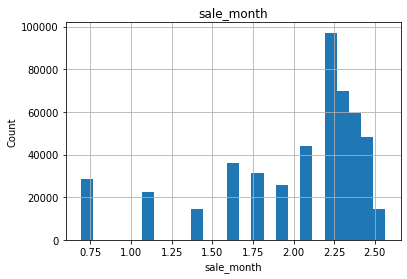

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


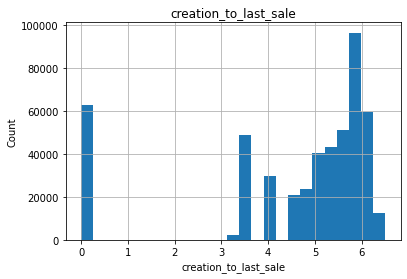

In [198]:
for feature in num_features:
    data=df.copy()
    np.log1p(data[feature]).hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

## Log Transformation

In [199]:
log_features=[f for f in num_features if f not in ['last_sale_price']]

In [200]:
''' Converting all the numerical features using log transformation, this had significantly improved the performance.'''
for f in log_features:
  df[f]=np.log1p(df[f])
  df[f].fillna(0,inplace=True)

In [201]:
df[num_features].max()

global_index               13.334473
nft_id                     10.784296
collection_id               4.110874
rarity_score               11.937690
openrarity_score            1.539838
last_sale_price          1024.001504
n_tweets_in_range           6.505784
avg_likes                   6.563679
avg_replies                 5.870426
avg_retweets                6.093570
min_likes                   5.468060
min_replies                 3.970292
min_retweets                3.850148
max_likes                   8.533067
max_replies                 7.864036
max_retweets                8.003363
total_supply               10.974249
n_of_traits                 4.394449
seller_fees                 6.908755
openrarity_enabled          0.693147
has_discord                 0.693147
has_medium                  0.693147
sale_year                   7.612337
sale_month                  2.564949
creation_to_last_sale       6.507278
dtype: float64

In [202]:
df[num_features].head()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,last_sale_price,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets,total_supply,n_of_traits,seller_fees,openrarity_enabled,has_discord,has_medium,sale_year,sale_month,creation_to_last_sale
0,9.995565,0.000000,3.912023,1.098612,0.0,1.266732,3.465736,5.241576,2.228973,4.126093,0.0,0.0,1.098612,6.383507,3.367296,5.942799,0.693147,1.098612,6.908755,0.0,0.693147,0.0,7.612337,2.484907,5.370638
1,10.392742,0.000000,3.828641,4.585755,0.0,1.200357,2.484907,4.899196,2.671009,4.028593,0.0,0.0,2.079442,5.998937,3.871201,5.480639,9.092570,1.791759,6.216606,0.0,0.693147,0.0,7.611842,2.197225,3.465736
2,10.392773,0.693147,3.828641,4.944874,0.0,3.180572,2.484907,4.899196,2.671009,4.028593,0.0,0.0,2.079442,5.998937,3.871201,5.480639,9.092570,1.791759,6.216606,0.0,0.693147,0.0,7.612337,2.197225,5.983936
3,10.392803,1.098612,3.828641,4.857899,0.0,3.502910,2.484907,4.899196,2.671009,4.028593,0.0,0.0,2.079442,5.998937,3.871201,5.480639,9.092570,1.791759,6.216606,0.0,0.693147,0.0,7.611842,2.197225,3.465736
4,10.392834,1.386294,3.828641,4.730178,0.0,4.009567,2.484907,4.899196,2.671009,4.028593,0.0,0.0,2.079442,5.998937,3.871201,5.480639,9.092570,1.791759,6.216606,0.0,0.693147,0.0,7.612337,2.302585,6.059123


## Encoding
### There are many encoding techniques like label, one-hot, mean encoding, count encoding, count based label, target guided mean, cluster encoding. Target guided works well in classification problems and count based labelling/one hot works well for regression problem, based on what i have seen practically

In [203]:
cat_features=[feature for feature in df.columns if df[feature].dtypes=='O'] 
cat_features

['openrarity_rank',
 'openrarity_max_rank',
 'last_sale_date',
 'creation_date',
 'verification_status',
 'contract_type']

In [204]:
df[cat_features].nunique()

openrarity_rank        15556
openrarity_max_rank       11
last_sale_date            22
creation_date             19
verification_status        2
contract_type              2
dtype: int64

In [205]:
high_features=[feature for feature in cat_features if  df[feature].nunique()>22]
high_features

['openrarity_rank']

In [206]:
df[high_features].nunique()

openrarity_rank    15556
dtype: int64

In [207]:
low_features=[feature for feature in cat_features if feature not in high_features and 'open' not in feature]
low_features

['last_sale_date', 'creation_date', 'verification_status', 'contract_type']

### Target guided mean encoding

In [87]:
# for feature in high_features:
#   cat_labels=df.groupby([feature])['last_sale_price'].mean().sort_values().index
#   cat_lables2={k:i for i,k in enumerate(cat_labels,0)}
#   df[feature]=df[feature].map(cat_lables2)
#   print(feature)

### Count Based Label Encoding

In [208]:
cat_features=[feature for feature in df.columns if df[feature].dtypes=='O'] 
cat_features

['openrarity_rank',
 'openrarity_max_rank',
 'last_sale_date',
 'creation_date',
 'verification_status',
 'contract_type']

In [209]:
for feature in low_features:
  dic=df[feature].value_counts().to_dict()
  list1=np.arange(len(dic.values()),0,-1) # If highest rank for high count
  # list1=np.arange(len(dic.values()))
  dic2=dict(zip(list(dic.keys()),list1))
  df[feature]=df[feature].replace(dic2)
  print(feature)

last_sale_date
creation_date
verification_status
contract_type


### One hot Encoding

In [210]:
one_hot_features=[feature for feature in df.columns if df[feature].dtype=='O']
one_hot_features

['openrarity_rank', 'openrarity_max_rank']

#### rare categorical features

#### remove categorical variables that are present less than 1% of the observations. Applying this only to one hot encoding and this would not let one hot method to create so many columns, the last grouped column can even be dropped later on

In [212]:
df[one_hot_features].nunique()

openrarity_rank        15556
openrarity_max_rank       11
dtype: int64

In [213]:
for feature in one_hot_features:
    temp=df.groupby(feature)['last_sale_price'].count()/len(df)
    temp_df=temp[temp>0.0005].index
    df[feature]=np.where(df[feature].isin(temp_df),df[feature],feature+'Rare_var')
# if the feature has less than 1%, create new feature

In [215]:
df[one_hot_features].nunique()
'''15556 categories are clubbed and made into two bins'''

'15556 categories are clubbed and made into two bins'

In [216]:
def category_onehot_multcols(df,multcolumns):
    df_final=df
    i=0
    for fields in multcolumns:
        print(fields)
        df1=pd.get_dummies(df[fields],drop_first=True)
        df.drop([fields],axis=1,inplace=True)
        if i==0:
            df_final=df1.copy()
        else:
            
            df_final=pd.concat([df_final,df1],axis=1)
        i=i+1
    df=pd.concat([df,df_final],axis=1)
        
    return df

In [217]:
df=category_onehot_multcols(df,one_hot_features)

openrarity_rank
openrarity_max_rank


In [218]:
df.head()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,last_sale_date,last_sale_price,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets,total_supply,creation_date,verification_status,n_of_traits,contract_type,seller_fees,openrarity_enabled,has_discord,has_medium,sale_year,sale_month,creation_to_last_sale,openrarity_rankRare_var,15000.0,15555.0,5555.0,8849.0,9928.0,9999.0,nan,openrarity_max_rankRare_var
0,9.995565,0.000000,3.912023,1.098612,0.0,18,1.266732,3.465736,5.241576,2.228973,4.126093,0.0,0.0,1.098612,6.383507,3.367296,5.942799,0.693147,18,1,1.098612,2,6.908755,0.0,0.693147,0.0,7.612337,2.484907,5.370638,0,0,0,0,0,0,0,1,0
1,10.392742,0.000000,3.828641,4.585755,0.0,9,1.200357,2.484907,4.899196,2.671009,4.028593,0.0,0.0,2.079442,5.998937,3.871201,5.480639,9.092570,14,1,1.791759,2,6.216606,0.0,0.693147,0.0,7.611842,2.197225,3.465736,0,0,0,0,0,0,0,1,0
2,10.392773,0.693147,3.828641,4.944874,0.0,22,3.180572,2.484907,4.899196,2.671009,4.028593,0.0,0.0,2.079442,5.998937,3.871201,5.480639,9.092570,14,1,1.791759,2,6.216606,0.0,0.693147,0.0,7.612337,2.197225,5.983936,0,0,0,0,0,0,0,1,0
3,10.392803,1.098612,3.828641,4.857899,0.0,9,3.502910,2.484907,4.899196,2.671009,4.028593,0.0,0.0,2.079442,5.998937,3.871201,5.480639,9.092570,14,1,1.791759,2,6.216606,0.0,0.693147,0.0,7.611842,2.197225,3.465736,0,0,0,0,0,0,0,1,0
4,10.392834,1.386294,3.828641,4.730178,0.0,21,4.009567,2.484907,4.899196,2.671009,4.028593,0.0,0.0,2.079442,5.998937,3.871201,5.480639,9.092570,14,1,1.791759,2,6.216606,0.0,0.693147,0.0,7.612337,2.302585,6.059123,0,0,0,0,0,0,0,1,0


In [219]:
df.shape

(491124, 38)

In [99]:
# df.describe()

### New Features
#### tried to create some new features like total likes from n_tweets_in_range* avg_likes but all these features were not improving the performance.

In [226]:
'''Total Likes'''
# df['total_likes']=df['avg_likes']*df['n_tweets_in_range']
'''Total Retweets'''
# df['total_retweets']=df['avg_retweets']*df['n_tweets_in_range']
'''Total Replies'''
# df['total_repies']=df['avg_replies']*df['n_tweets_in_range']

'Total Replies'

In [230]:
'''Collection Count across each nft'''
# df_collection_count=df.groupby('nft_id').agg({"collection_id":'count'}).reset_index()
# df_collection_count.columns=['nft_id','collection_count']

'Collection Count across each nft'

In [231]:
# df=pd.merge(df,df_collection_count, on=['nft_id'],how='left')

In [232]:
# df.head()

In [233]:
''' NFT count present in each collection'''
# df_nft_count=df.groupby('collection_id').agg({"nft_id":'count'}).reset_index()
# df_nft_count.columns=['collection_id','nft_count']

' NFT count present in each collection'

In [234]:
# df=pd.merge(df,df_nft_count, on=['collection_id'],how='left')

In [235]:
# df.head()

In [236]:
# df['nft_count']=df.replace(df['nft_id'].value_counts().to_dict())

In [237]:
# tot_nft_count=df.groupby('nft_id').agg({"nft_id":'count'})
# tot_nft_count.columns=['nft_total_count']
# tot_nft_count.reset_index(inplace=True)

In [238]:
# df=pd.merge(df,tot_nft_count, on=['nft_id'],how='left')

In [239]:
# tot_collection_count=df.groupby('collection_id').agg({"collection_id":'count'})
# tot_collection_count.columns=['collection_total_count']
# tot_collection_count.reset_index(inplace=True)

In [240]:
# df=pd.merge(df,tot_collection_count, on=['collection_id'],how='left')

In [241]:
# df.info()

# feature scaling

In [242]:
feature_scale=[feature for feature in df.columns if feature not in ['last_sale_price']]

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler=StandardScaler()

In [243]:
df[feature_scale]=scaler.fit_transform(df[feature_scale])

In [244]:
final_df=df.copy()
final_df.shape

(491124, 38)

In [245]:
final_df.head()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,last_sale_date,last_sale_price,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets,total_supply,creation_date,verification_status,n_of_traits,contract_type,seller_fees,openrarity_enabled,has_discord,has_medium,sale_year,sale_month,creation_to_last_sale,openrarity_rankRare_var,15000.0,15555.0,5555.0,8849.0,9928.0,9999.0,nan,openrarity_max_rankRare_var
0,-2.432025,-6.999358,0.813622,-2.940693,-0.561648,0.122459,1.266732,0.947537,1.439493,0.380163,1.201866,-0.747717,-0.640385,0.082130,1.398811,0.446277,1.400544,-12.259114,1.071204,-1.089063,-2.375507,0.880729,1.037420,-0.565829,0.820615,-0.326514,0.342080,0.958217,0.422459,-0.565829,-0.177495,-0.180854,-0.152135,-0.13576,-0.143638,-0.206027,0.565829,-0.198551
1,-2.026188,-6.999358,0.728050,-0.468541,-0.561648,-2.047277,1.200357,0.208027,1.235307,0.705850,1.144705,-0.747717,-0.640385,0.907442,1.199975,0.747738,1.180244,-0.607367,0.281865,-1.089063,-1.070886,0.880729,-0.424798,-0.565829,0.820615,-0.326514,-2.923295,0.363493,-0.567870,-0.565829,-0.177495,-0.180854,-0.152135,-0.13576,-0.143638,-0.206027,0.565829,-0.198551
2,-2.026157,-6.428333,0.728050,-0.213949,-0.561648,1.086786,3.180572,0.208027,1.235307,0.705850,1.144705,-0.747717,-0.640385,0.907442,1.199975,0.747738,1.180244,-0.607367,0.281865,-1.089063,-1.070886,0.880729,-0.424798,-0.565829,0.820615,-0.326514,0.342080,0.363493,0.741303,-0.565829,-0.177495,-0.180854,-0.152135,-0.13576,-0.143638,-0.206027,0.565829,-0.198551
3,-2.026125,-6.094305,0.728050,-0.275608,-0.561648,-2.047277,3.502910,0.208027,1.235307,0.705850,1.144705,-0.747717,-0.640385,0.907442,1.199975,0.747738,1.180244,-0.607367,0.281865,-1.089063,-1.070886,0.880729,-0.424798,-0.565829,0.820615,-0.326514,-2.923295,0.363493,-0.567870,-0.565829,-0.177495,-0.180854,-0.152135,-0.13576,-0.143638,-0.206027,0.565829,-0.198551
4,-2.026094,-5.857308,0.728050,-0.366154,-0.561648,0.845705,4.009567,0.208027,1.235307,0.705850,1.144705,-0.747717,-0.640385,0.907442,1.199975,0.747738,1.180244,-0.607367,0.281865,-1.089063,-1.070886,0.880729,-0.424798,-0.565829,0.820615,-0.326514,0.342080,0.581304,0.780392,-0.565829,-0.177495,-0.180854,-0.152135,-0.13576,-0.143638,-0.206027,0.565829,-0.198551


In [246]:
df_Train=final_df.iloc[:final_df.shape[0]-test.shape[0],:]
df_Test=final_df.iloc[final_df.shape[0]-test.shape[0]:,:]

In [247]:
(df_Train.shape,df_Test.shape)

((309910, 38), (181214, 38))

In [248]:
df_Test.drop(['last_sale_price'],axis=1,inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [249]:
X_train=df_Train.drop(['last_sale_price'],axis=1)
y_train=df_Train['last_sale_price']

X_full=X_train.copy()
y_full=y_train.copy()
    
X_train,x_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size = 0.1,random_state=1)

# Modeling

In [250]:
''' Fit a basic OLS and see the p-value, AIC/BIC. Based on this we can decide whether to keep/drop/transform features'''
reg_ols= sm.OLS(np.log(y_train), X_train)
results = reg_ols.fit()
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Ordinary least squares
=============================================================================
Model:                  OLS                Adj. R-squared:       0.540       
Dependent Variable:     last_sale_price    AIC:                  1175839.1980
Date:                   2023-02-20 05:23   BIC:                  1176208.0516
No. Observations:       278919             Log-Likelihood:       -5.8788e+05 
Df Model:               34                 F-statistic:          9621.       
Df Residuals:           278884             Prob (F-statistic):   0.00        
R-squared:              0.540              Scale:                3.9658      
-----------------------------------------------------------------------------
                             Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
-----------------------------------------------------------------------------
global_index                -0.3882   0.0137  -28.3639 0.0000 -0.4151 -0.3614
nft_id                      -0.0363   0.0046   -7.8229 0.0000 -0.0454 -0.0272
collection_id               -0.0997   0.0166   -6.0142 0.0000 -0.1322 -0.0672
rarity_score                -0.0644   0.0127   -5.0744 0.0000 -0.0892 -0.0395
openrarity_score             0.0879   0.0332    2.6489 0.0081  0.0229  0.1529
last_sale_date               0.1070   0.0087   12.2997 0.0000  0.0899  0.1240
n_tweets_in_range            0.2351   0.0189   12.4648 0.0000  0.1982  0.2721
avg_likes                    0.7062   0.0890    7.9342 0.0000  0.5318  0.8807
avg_replies                 -3.6829   0.0637  -57.7966 0.0000 -3.8078 -3.5580
avg_retweets                 1.5140   0.0829   18.2606 0.0000  1.3515  1.6765
min_likes                   -1.8271   0.0253  -72.2923 0.0000 -1.8767 -1.7776
min_replies                  3.6657   0.0388   94.4365 0.0000  3.5896  3.7418
min_retweets                -0.2558   0.0310   -8.2536 0.0000 -0.3165 -0.1950
max_likes                    1.5423   0.0897   17.1859 0.0000  1.3664  1.7182
max_replies                  0.5184   0.0471   11.0002 0.0000  0.4261  0.6108
max_retweets                 0.1196   0.0827    1.4470 0.1479 -0.0424  0.2816
total_supply                 1.0957   0.0184   59.5056 0.0000  1.0596  1.1318
creation_date               -0.5236   0.0128  -40.9455 0.0000 -0.5487 -0.4986
verification_status          0.3857   0.0269   14.3487 0.0000  0.3331  0.4384
n_of_traits                 -0.5577   0.0157  -35.5898 0.0000 -0.5884 -0.5270
contract_type                1.3661   0.0229   59.5828 0.0000  1.3211  1.4110
seller_fees                 -1.0932   0.0108 -101.2841 0.0000 -1.1143 -1.0720
openrarity_enabled          -0.7278   0.0164  -44.3023 0.0000 -0.7600 -0.6956
has_discord                  0.2664   0.0230   11.5950 0.0000  0.2214  0.3115
has_medium                   0.0670   0.0184    3.6453 0.0003  0.0310  0.1030
sale_year                    0.0958   0.0089   10.8007 0.0000  0.0784  0.1132
sale_month                  -0.1105   0.0068  -16.2909 0.0000 -0.1238 -0.0972
creation_to_last_sale       -0.2241   0.0066  -34.0146 0.0000 -0.2370 -0.2112
openrarity_rankRare_var     -0.7278   0.0164  -44.3023 0.0000 -0.7600 -0.6956
15000.0                      0.1386   0.0201    6.8797 0.0000  0.0991  0.1780
15555.0                      1.0122   0.0199   50.9270 0.0000  0.9733  1.0512
5555.0                       0.8749   0.0159   54.8654 0.0000  0.8436  0.9061
8849.0                       0.5507   0.0134   41.1030 0.0000  0.5244  0.5770
9928.0                       0.4912   0.0179   27.3822 0.0000  0.4560  0.5263
9999.0                      -0.2810   0.0121  -23.3158 0.0000 -0.3047 -0.2574
nan                          0.7278   0.0164   44.3023 0.0000  0.6956  0.7600
openrarity_max_rankRare_var 17.8692   0.0583  306.7602 0.0000 17.7551 17.9834
-----------------------------------------------------------------------------
Omnibus:              39032.890      Durbin-Watson:         1.999         

In [251]:
y_v_sm=np.exp(results.predict(x_valid))
y_t_sm=np.exp(results.predict(df_Test))

In [252]:
''' Defined the RMSE based on the problem statement'''
def rmse(predictions, targets):
    r= np.sqrt(((predictions - targets) ** 2).mean())
    return np.exp(-r/10 )

In [253]:
rmse(y_v_sm,y_valid)

0.300032707226782

## Linear Regression

In [254]:
from sklearn.linear_model import LinearRegression
lin_reg=LinearRegression()

In [255]:
lin_reg.fit(X_train,np.log(y_train))
y_v_lg=np.exp(lin_reg.predict(x_valid))
y_t_lg=np.exp(lin_reg.predict(df_Test))

In [256]:
y_v_lg

array([0.06057215, 0.00401305, 0.0030445 , ..., 0.10346147, 0.0078998 ,
       0.00333619])

In [257]:
rmse(y_v_lg,y_valid)

0.300032707226782

In [258]:
y_t_lg

array([3.38727138, 4.08617243, 1.86823567, ..., 0.01993946, 0.01993936,
       0.02711511])

## Decision Trees

In [259]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(max_depth=11,random_state=42)

In [260]:
tree_reg.fit(X_train,np.log(y_train))

DecisionTreeRegressor(max_depth=11, random_state=42)

In [261]:
y_pred_valid1=np.exp(tree_reg.predict(x_valid))

In [262]:
y_test1=np.exp(tree_reg.predict(df_Test))
y_test1

array([1.21536628, 0.05507986, 2.94187869, ..., 0.00353374, 0.00353374,
       0.00373981])

In [263]:
rmse(y_pred_valid1,y_valid)

0.3773858191198731

In [265]:
''' Find the best max depth for Decision Trees'''
tree_reg = DecisionTreeRegressor(random_state=42)
min_val_error = float("inf")
error_going_up = 0
for max_depth in range(1, 100):
    tree_reg.max_depth = max_depth
    tree_reg.fit(X_train, y_train)
    y_pred = tree_reg.predict(x_valid)
    val_error = rmse(y_valid, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 10:
            break  # early stopping

In [266]:
print(tree_reg.max_depth)

11


## Extra Trees regressor

In [267]:
from sklearn.ensemble import ExtraTreesRegressor
# etr = ExtraTreesRegressor(max_depth=12, min_samples_leaf=35, min_samples_split=25,
#                     n_jobs=4)
etr=ExtraTreesRegressor(max_depth=12, min_samples_leaf=20, min_samples_split=25,
                    n_jobs=4)
etr.fit(X_train,np.log(y_train))

ExtraTreesRegressor(max_depth=12, min_samples_leaf=20, min_samples_split=25,
                    n_jobs=4)

In [268]:
y_v_etr=np.exp(etr.predict(x_valid))
y_t_etr=np.exp(etr.predict(df_Test))
y_t_etr

array([0.12336606, 0.09932152, 0.14254916, ..., 0.01284458, 0.01284458,
       0.0099298 ])

In [269]:
y_v_etr

array([0.0795322 , 0.00375496, 0.00371905, ..., 0.04187744, 0.00476387,
       0.00375865])

In [270]:
rmse(y_v_etr,y_valid)

0.3568438792770094

In [271]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

### Hyper parameter Tuning

In [272]:
n_estimators = [30,35, 40,45, 50,55, 60,65, 70,75,100]
max_depth = [2, 4, 5, 6,8,10,12,14]
min_samples_leaf=[10,20,35,40,60,80]
min_samples_split=[5,15,25,35,45,60]


# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'min_samples_leaf':min_samples_leaf,
    'min_samples_leaf':min_samples_leaf
    }

In [273]:
from sklearn.model_selection import RandomizedSearchCV 
random_cv_etr = RandomizedSearchCV(estimator=etr,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=15,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

In [ ]:
random_cv_etr.fit(X_train[:15000],y_train[:15000]) 
''' taking only a subset to tune, since the data size is huge'''

Fitting 5 folds for each of 15 candidates, totalling 75 fits


RandomizedSearchCV(cv=5,
                   estimator=ExtraTreesRegressor(max_depth=12,
                                                 min_samples_leaf=35,
                                                 min_samples_split=25,
                                                 n_jobs=4),
                   n_iter=15, n_jobs=4,
                   param_distributions={'max_depth': [2, 4, 5, 6, 8, 10, 12,
                                                      14],
                                        'min_samples_leaf': [10, 20, 35, 40, 60,
                                                             80],
                                        'n_estimators': [30, 35, 40, 45, 50, 55,
                                                         60, 65, 70, 75, 100]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=5)

In [ ]:
random_cv_etr.best_estimator_

ExtraTreesRegressor(max_depth=12, min_samples_leaf=20, min_samples_split=25,
                    n_jobs=4)

## Gradient Boosting

In [282]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=5, min_samples_split=200, n_estimators=50,
                          random_state=42)
gbrt.fit(X_train, np.log(y_train))

GradientBoostingRegressor(max_depth=5, min_samples_split=200, n_estimators=50,
                          random_state=42)

In [283]:
y_pred_test2=np.exp(gbrt.predict(df_Test))
    
y_pred_valid2=np.exp(gbrt.predict(x_valid))
rmse(y_pred_valid2,y_valid)

0.3431135323906099

In [284]:
y_pred_test2

array([0.63475319, 0.16462764, 0.72409337, ..., 0.01116   , 0.01116   ,
       0.00642509])

### Hyper parameter Tuning

In [ ]:
n_estimators = [30, 40,50, 60,70,80,100,150]
max_depth = [2, 4, 5, 6,8,10,12,14]
learning_rate=[0.1,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23]
min_samples_split=[50,100,200,400,600,800,1000]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_samples_split':min_samples_split
    }

In [ ]:
from sklearn.model_selection import RandomizedSearchCV 
random_cv_grt = RandomizedSearchCV(estimator=gbrt,
            param_distributions=hyperparameter_grid,
            cv=10, n_iter=15,
            scoring = 'neg_root_mean_squared_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

In [ ]:
random_cv_grt.fit(X_train[:10000],y_train[:10000])

Fitting 10 folds for each of 15 candidates, totalling 150 fits


RandomizedSearchCV(cv=10,
                   estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                       max_depth=12,
                                                       n_estimators=80,
                                                       random_state=42),
                   n_iter=15, n_jobs=4,
                   param_distributions={'learning_rate': [0.1, 0.15, 0.16, 0.17,
                                                          0.18, 0.19, 0.2, 0.21,
                                                          0.22, 0.23],
                                        'max_depth': [2, 4, 5, 6, 8, 10, 12,
                                                      14],
                                        'min_samples_split': [50, 100, 200, 400,
                                                              600, 800, 1000],
                                        'n_estimators': [30, 40, 50, 60, 70, 80,
                                   

In [ ]:
random_cv_grt.best_estimator_

GradientBoostingRegressor(max_depth=5, min_samples_split=200, n_estimators=50,
                          random_state=42)

## Light GBM

In [308]:
import lightgbm

In [309]:
light_gbm = lightgbm.LGBMRegressor(bagging_fraction=0.7, bagging_freq=5, bagging_seed=7,
              feature_fraction=0.2, feature_fraction_seed=7, lambda_l1=1,
              learning_rate=0.2, max_bin=200, max_depth=10, min_data_in_leaf=20,
              n_estimators=200, num_leaves=20, objective='regression',
              verbose=-1)

In [310]:
light_gbm.fit(X_train,np.log(y_train))

LGBMRegressor(bagging_fraction=0.7, bagging_freq=5, bagging_seed=7,
              feature_fraction=0.2, feature_fraction_seed=7, lambda_l1=1,
              learning_rate=0.2, max_bin=200, max_depth=10, min_data_in_leaf=20,
              n_estimators=200, num_leaves=20, objective='regression',
              verbose=-1)

In [311]:
y_v_lgbm=np.exp(light_gbm.predict(x_valid))
y_t_lgbm=np.exp(light_gbm.predict(df_Test))

In [312]:
rmse(y_valid,y_v_lgbm)

0.3574905365533918

In [313]:
y_t_lgbm

array([0.10831277, 0.18797371, 0.21284615, ..., 0.01201648, 0.01201648,
       0.0048469 ])

### Hyper parameter Tuning

In [314]:
num_leaves = [2,3,4,5, 10, 20, 30,40, 50, 100, 150]
max_depth = [2, 4, 5, 6,8,10,12,14]
learning_rate=[0.01,0.02,0.03,0.05,0.1,0.20,]
min_data_in_leaf=[10,20,30,40, 50]
bagging_fraction= [0.7, 0.8, 0.9]
feature_fraction=[0.2, 0.5, 0.75]
lambda_l1=[0, 1, 2,10]
n_estimators = [30, 40,50, 60,70,80,100,200]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_data_in_leaf':min_data_in_leaf,
    'bagging_fraction':bagging_fraction,
    'feature_fraction':feature_fraction,
    'lambda_l1':lambda_l1,
    'num_leaves':num_leaves

    }

In [315]:
from sklearn.model_selection import RandomizedSearchCV 
random_cv_lgbm = RandomizedSearchCV(estimator=light_gbm,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=30,
            scoring = 'neg_root_mean_squared_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

In [ ]:
random_cv_lgbm.fit(X_train,np.log(y_train))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(bagging_fraction=0.9, bagging_freq=5,
                                           bagging_seed=7,
                                           feature_fraction=0.75,
                                           feature_fraction_seed=7, lambda_l1=2,
                                           learning_rate=0.2, max_bin=200,
                                           max_depth=4, min_data_in_leaf=10,
                                           n_estimators=80, num_leaves=40,
                                           objective='regression', verbose=-1),
                   n_iter=30, n_jobs=4,
                   param_distributions={'bagging_fraction': [0.7, 0....
                                        'feature_fraction': [0.2, 0.5, 0.75],
                                        'lambda_l1': [0, 1, 2, 10],
                                        'learning_rate': [0.01, 0.02, 0.03,
                                               

In [ ]:
random_cv_lgbm.best_estimator_

LGBMRegressor(bagging_fraction=0.7, bagging_freq=5, bagging_seed=7,
              feature_fraction=0.2, feature_fraction_seed=7, lambda_l1=1,
              learning_rate=0.2, max_bin=200, max_depth=10, min_data_in_leaf=20,
              n_estimators=200, num_leaves=20, objective='regression',
              verbose=-1)

## Random Forests

In [316]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_leaf=4, min_samples_split=5, random_state=42)

In [317]:
rf.fit(X_train,np.log(y_train))

RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_leaf=4, min_samples_split=5, random_state=42)

In [ ]:
y_v_rf=np.exp(rf.predict(x_valid))
y_t_rf=np.exp(rf.predict(df_Test))
    
rmse(y_v_rf,y_valid)

0.3473763094052254

In [ ]:
y_t_rf

array([0.15579756, 0.14266266, 0.15941161, ..., 0.00902793, 0.00902793,
       0.01065702])

### Hyper parameter Tuning

In [318]:
min_samples_leaf = [1, 2, 4]
max_depth = [2, 4, 5, 6,8,10,12,14]
max_features = ['auto', 'sqrt']
min_samples_split = [2, 5, 10]
n_estimators = [30, 40,50, 60,70,80,100]
criterion=["squared_error", "absolute_error", "friedman_mse"]
bootstrap = [True, False]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf,
    "criterion":criterion,
    'max_features':max_features,
    'bootstrap':bootstrap
    }

In [319]:
from sklearn.model_selection import RandomizedSearchCV 
random_cv_rf = RandomizedSearchCV(estimator=rf,
            param_distributions=hyperparameter_grid,
            cv=3, n_iter=10,
            scoring = 'neg_root_mean_squared_error',n_jobs = -1,
            verbose = 500, 
            return_train_score = True,
            random_state=42)

In [ ]:
random_cv_rf.fit(X_train[:10000],np.log(y_train[:10000]))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['squared_error',
                                                      'absolute_error',
                                                      'friedman_mse'],
                                        'max_depth': [2, 4, 5, 6, 8, 10, 12,
                                                      14],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [30, 40, 50, 60, 70, 80,
                                                         100]},
                   random_state=42, return_train_score=True,
                   scoring='neg_root_mean_squared_err

In [ ]:
rf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [ ]:
random_cv_rf.best_estimator_

RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_leaf=4, min_samples_split=5, random_state=42)

## XGBoost

In [285]:
import xgboost
regressor=xgboost.XGBRegressor(base_score=0.75, gpu_id=1, interaction_constraints='',
             learning_rate=0.15, max_depth=2, min_child_weight=3,
             monotone_constraints='(1,-1)', n_estimators=50, n_jobs=4,
             num_parallel_tree=1, tree_method='exact', validate_parameters=1,
             verbosity=3)
regressor.fit(X_train,np.log(y_train))

[05:34:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:34:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[05:34:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[05:34:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[05:34:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[05:34:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[05:34:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[05:34:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pru

XGBRegressor(base_score=0.75, gpu_id=1, interaction_constraints='',
             learning_rate=0.15, max_depth=2, min_child_weight=3,
             monotone_constraints='(1,-1)', n_estimators=50, n_jobs=4,
             num_parallel_tree=1, tree_method='exact', validate_parameters=1,
             verbosity=3)

In [286]:
y_t_xg=np.exp(regressor.predict(df_Test))
    
y_p_xg=np.exp(regressor.predict(x_valid))
rmse(y_p_xg,y_valid)

0.2971991028294597

In [287]:
y_t_xg

array([0.26255566, 0.2721948 , 0.24033462, ..., 0.00205509, 0.00205509,
       0.00205509], dtype=float32)

### Hyper parameter Tuning

In [288]:
booster=['gbtree','gblinear']
base_score=[0.25,0.5,0.75,1]

In [289]:
## Hyper Parameter Optimization


n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

In [290]:
from sklearn.metrics import SCORERS
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [291]:
random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=20,
            scoring = 'neg_root_mean_squared_error',n_jobs = 5,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

In [ ]:
random_cv.fit(X_train[:20000],y_train[:20000])

In [ ]:
random_cv.best_estimator_

## KNNs

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
knn=KNeighborsRegressor(n_neighbors=8)

In [ ]:
knn.fit(X_full,np.log(y_full))

KNeighborsRegressor(n_neighbors=8)

In [274]:
# k_opt=0
# error=0
# for i in range(2,40):
#   knn=KNeighborsRegressor(n_neighbors=i)
#   knn.fit(X_train,y_train)
#   y_k=knn.predict(x_valid[:1000])
#   if rmse(y_k,y_valid[:1000])>error:
#     error=rmse(y_k,y_valid[:1000])
#     k_opt=i
#     print(error,i)

In [ ]:
# y_p_knn=knn.predict(X_train)
y_v_knn=knn.predict(x_valid)
y_t_knn=np.exp(knn.predict(df_Test))

In [ ]:
rmse(y_v_knn,y_valid)

NameError: ignored

In [ ]:
y_v_knn

In [ ]:
y_t_knn

array([3.05013244, 3.00196096, 3.07832256, ..., 0.02334857, 0.02334857,
       0.00565239])

## Panel Regression
### The idea is that the entire dataset shows no particular patterns, so The data can be broken down in to sets and fit algoritm that performs well in each set. Ideally this should be done on a feature that has multiple rows for a particular nft_id. However, I have decided to make clusters and then fit algos for each clusters.

Below is a generic function to fit any algorithm

### Normal Generic Panel function

In [275]:
def panel(df,alg,variable,error_func,pred_features,test):
  variable_val=np.array(list(df[variable].unique()))
  ID=df.copy()
  output=pd.DataFrame(columns=ID.columns)
  small_count=[]
  df_train=df.iloc[df.shape[0]-test.shape[0]:]
  for i in range(len(variable_val)):
    print(i)
    df_temp=df[df[variable]==variable_val[i]]
    df_train_temp=df_temp[df_temp[pred_features].isna()==False]
    df_test_temp=df_temp[df_temp[pred_features].isna()==True]
    # print(df_train_temp.shape,df_test_temp.shape)
    if df_test_temp.shape[0]<4 or df_train_temp.shape[0]<4: # 4 was decided to have KNN use n neighbors at least of 4
      small_count.append(variable_val[i])
      continue
    else:
      df_test_temp=df_test_temp.drop(columns=[pred_features])
      x_train_temp=df_train_temp.drop(columns=[pred_features])
      y_train_temp=df_train_temp[pred_features]

      alg.fit(x_train_temp,y_train_temp)
      df_test_temp[pred_features]=alg.predict(df_test_temp)
      output=pd.concat([output,df_test_temp],axis='rows')


  ID=ID.drop(columns=[pred_features])
  final_out=output[[pred_features]]
  ID=pd.concat([ID,final_out],axis="columns")
  df2=ID.copy()
  df_train_temp=df2[df2[pred_features].isna()==False]
  df_test_temp=df2[df2[pred_features].isna()==True]
  df_test_temp=df_test_temp.drop(columns=[pred_features])
  x_train_temp=df_train_temp.drop(columns=[pred_features])
  y_train_temp=df_train_temp[pred_features]

  alg.fit(x_train_temp,y_train_temp)
  df_test_temp[pred_features]=alg.predict(df_test_temp)
  output=pd.concat([output,df_test_temp],axis='rows')

  ID=ID.drop(columns=[pred_features])

  ID=pd.concat([ID,output[[pred_features]]],axis="columns")
  # 
  return(ID[[pred_features]])


### Hyper Parameter Tuned Generic Panel Regression

In [307]:
'''Below is Tuned Panel Regression where every algorithm gets its hyper paramaters tuned for each subset'''

'Below is Tuned Panel Regression where every algorithm gets its hyper paramaters tuned for each subset'

In [306]:
def panel_tune(df,alg,variable,error_func,pred_features,test,hyp):
  variable_val=np.array(list(df[variable].unique()))
  ID=df.copy()
  output=pd.DataFrame(columns=ID.columns)
  small_count=[]
  df_train=df.iloc[df.shape[0]-test.shape[0]:]
  for i in range(len(variable_val)):
    print(i)
    df_temp=df[df[variable]==variable_val[i]]
    df_train_temp=df_temp[df_temp[pred_features].isna()==False]
    df_test_temp=df_temp[df_temp[pred_features].isna()==True]
    # print(df_train_temp.shape,df_test_temp.shape)
    if df_test_temp.shape[0]<4 or df_train_temp.shape[0]<4:
      small_count.append(variable_val[i])
      continue
    else:
      df_test_temp=df_test_temp.drop(columns=[pred_features])
      x_train_temp=df_train_temp.drop(columns=[pred_features])
      y_train_temp=df_train_temp[pred_features]
      hyp.fit(x_train_temp,y_train_temp)
      best_est=hyp.best_estimator_
      print(best_est)
      best_est.fit(x_train_temp,y_train_temp)
      df_test_temp[pred_features]=best_est.predict(df_test_temp)
      output=pd.concat([output,df_test_temp],axis='rows')


  ID=ID.drop(columns=[pred_features])
  final_out=output[[pred_features]]
  ID=pd.concat([ID,final_out],axis="columns")
  df2=ID.copy()
  df_train_temp=df2[df2[pred_features].isna()==False]
  df_test_temp=df2[df2[pred_features].isna()==True]
  df_test_temp=df_test_temp.drop(columns=[pred_features])
  x_train_temp=df_train_temp.drop(columns=[pred_features])
  y_train_temp=df_train_temp[pred_features]

  hyp.fit(x_train_temp,y_train_temp)
  best_est=hyp.best_estimator_
  print(best_est)
  best_est.fit(x_train_temp,y_train_temp)
  df_test_temp[pred_features]=best_est.predict(df_test_temp)
  output=pd.concat([output,df_test_temp],axis='rows')

  ID=ID.drop(columns=[pred_features])

  ID=pd.concat([ID,output[[pred_features]]],axis="columns")
  # 
  return(ID[[pred_features]])


In [276]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

km = KMeans(n_clusters=25, random_state=1)
new =final_df.drop(columns=['last_sale_price'])

In [ ]:
visualizer = KElbowVisualizer(km, k=(1,30))
visualizer.fit(new)        # Fit the data to the visualizer
visualizer.show()

''' The optimal number of clusters were chosen based on this'''

In [277]:
km.fit(np.array(new))
predict=km.predict(new)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [278]:
final_df['cluster']=predict

In [279]:
final_df['cluster'].value_counts()

9     48552
2     48257
22    32540
15    32267
17    29899
24    28575
0     24190
3     21377
23    20216
12    19602
1     18887
4     18627
13    16206
6     15555
20    15441
5     15000
11    11110
10    10000
7     10000
18     9999
19     9999
8      9928
21     9508
14     8888
16     6501
Name: cluster, dtype: int64

In [280]:
new=final_df.copy()
new['last_sale_price']=np.log(new['last_sale_price'])

### Multi Fit Stacking
#### This would take a bit of time since panel regression is applied for a bunch of tree based algorithms and stacked

In [ ]:
alg_list=[tree_reg,etr,gbrt,regressor,light_gbm,rf]
names=['DT','ETR','GBRT','XGB','LGBM','RF']
for x in range(len(alg_list)):
  panel_temp=panel(new,alg_list[x],'cluster',rmse,'last_sale_price',test)
  if x==0:
    stack=panel_temp[final_df.shape[0]-test.shape[0]:]
  else:
    out=panel_temp[final_df.shape[0]-test.shape[0]:]
    stack=pd.concat([stack,out],axis='columns')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
[11:03:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:03:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[11:03:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:03:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:03:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:03:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:03:45] INFO: /workspace/src

#### Tuned Stacking

In [ ]:
'''All alogrithms are tuned and fit. This has taken hours to run'''
# alg_list=[etr,gbrt,regressor,light_gbm]
# hyp_list=[random_cv_etr,random_cv_gbrt,random_cv_xgb,random_cv_lgbm]
# names=['ETR','GBRT','XGB','LGBM']
# for x in range(len(alg_list)):
#   panel_temp=panel_tune(new,alg_list[x],'cluster',rmse,'last_sale_price',test,hyp_list[x])
#   if x==0:
#     stack=panel_temp[final_df.shape[0]-test.shape[0]:]
#   else:
#     out=panel_temp[final_df.shape[0]-test.shape[0]:]
#     stack=pd.concat([stack,out],axis='columns')

In [320]:
# stack.columns=names
# stack=np.exp(stack)
# stack.head()

In [321]:
# stack['last_sale_price']=(stack['ETR']+stack['GBRT']+stack['XGB']+stack['LGBM']+stack["DT"]+stack['RF'])/6

In [322]:
# stack.head()

### Normal Single Fit

In [292]:
panel_test=panel(new,gbrt,'cluster',rmse,'last_sale_price',test)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


### Tuned Single Fit

In [ ]:
# panel_test=panel_tune(new,gbrt,'cluster',rmse,'last_sale_price',test,random_cv_gbrt)

In [293]:
panel_sub=panel_test[final_df.shape[0]-test.shape[0]:]

In [294]:
np.exp(panel_sub)

,last_sale_price
309910,1.087091
309911,0.222507
309912,3.253762
309913,1.087091
309914,0.741355
...,...
491119,0.015088
491120,0.015594
491121,0.016552
491122,0.016552


In [295]:
panel_sub.isna().sum()

last_sale_price    0
dtype: int64

In [296]:
panel_sub['last_sale_price']=np.exp(panel_sub['last_sale_price'])

<ipython-input-296-04440d64c2e8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panel_sub['last_sale_price']=np.exp(panel_sub['last_sale_price'])


# Final

In [297]:
df_result=pd.DataFrame(panel_sub['last_sale_price'].to_list(),columns=["last_sale_price"]) #panel_sub['last_sale_price'].to_list()

In [298]:
df_result.head(10)

,last_sale_price
0,1.087091
1,0.222507
2,3.253762
3,1.087091
4,0.741355
5,1.087091
6,0.300568
7,1.078903
8,0.201318
9,0.267137


In [ ]:
s=pd.read_csv('/content/drive/MyDrive/NFT Price Prediction/dataset/submission_format.csv')

In [ ]:
s.head()

,global_index,last_sale_price
0,0,0.234588
1,1,0.243322
2,2,0.231398
3,3,0.150778
4,4,2.015249


In [ ]:
result=pd.concat([s['global_index'],df_result],axis='columns')

In [ ]:
result.head()

,global_index,last_sale_price
0,0.0,1.074734
1,1.0,0.387316
2,2.0,3.253762
3,3.0,1.074734
4,4.0,0.732928


In [ ]:
result.to_csv('result22.csv',index=False)

## Final Stacking
### The outputs from panel regression are stacked by Simple Mean. GBRT panel Single fit, Tuned GBRT Panel fit, & stacked multi fit results are stacked. The idea is to create a generic solution that performs well across all data points, using a single algorithm will only perform well on a certain portion. This is like taking each algoritm's advantage and mixing it with others.

Many submissions are made using panel regression( Single fit, multi fit, Tuned singe fit) for many tree based algorithms. Final submissionsa re stacked at the end

In [299]:
result22=pd.read_csv('/content/drive/MyDrive/NFT Price Prediction/dataset/result22.csv')

In [301]:
result22.head()

,global_index,last_sale_price
0,0.0,1.087091
1,1.0,0.222507
2,2.0,3.253762
3,3.0,1.087091
4,4.0,0.741355


In [304]:
result32=pd.read_csv('/content/drive/MyDrive/NFT Price Prediction/dataset/result32_panel_tune.csv')
result32.head()

,global_index,last_sale_price
0,0.0,0.960239
1,1.0,1.159658
2,2.0,2.664536
3,3.0,0.953177
4,4.0,0.833982


In [305]:
result34=pd.read_csv('/content/drive/MyDrive/NFT Price Prediction/dataset/result34.csv')
result34.head()

,global_index,last_sale_price
0,0.0,1.009332
1,1.0,1.028892
2,2.0,2.736051
3,3.0,1.009332
4,4.0,0.760658


In [323]:
mix=result22.copy()
mix['last_sale_price']=(result22['last_sale_price']
                        +result34['last_sale_price']
                        +result32['last_sale_price'])/3

In [324]:
mix.head()


,global_index,last_sale_price
0,0.0,1.018887
1,1.0,0.803686
2,2.0,2.884783
3,3.0,1.016533
4,4.0,0.778665


In [ ]:
mix.to_csv('result35_22_32_34.csv.csv',index=False)